<a href="https://colab.research.google.com/github/Utku-Genc/Weather-Modeling/blob/main/Web_Scraping_Modelleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/35 - Training Loss: 0.6101 - Validation Loss: 0.4918
Epoch 2/35 - Training Loss: 0.4449 - Validation Loss: 0.3868
Epoch 3/35 - Training Loss: 0.3880 - Validation Loss: 0.3537
Epoch 4/35 - Training Loss: 0.3702 - Validation Loss: 0.3442
Epoch 5/35 - Training Loss: 0.3606 - Validation Loss: 0.3395
Epoch 6/35 - Training Loss: 0.3579 - Validation Loss: 0.3363
Epoch 7/35 - Training Loss: 0.3527 - Validation Loss: 0.3341
Epoch 8/35 - Training Loss: 0.3477 - Validation Loss: 0.3340
Epoch 9/35 - Training Loss: 0.3453 - Validation Loss: 0.3333
Epoch 10/35 - Training Loss: 0.3432 - Validation Loss: 0.3339
Epoch 11/35 - Training Loss: 0.3395 - Validation Loss: 0.3285
Epoch 12/35 - Training Loss: 0.3380 - Validation Loss: 0.3283
Epoch 13/35 - Training Loss: 0.3353 - Validation Loss: 0.3282
Epoch 14/35 - Training Loss: 0.3359 - Validation Loss: 0.3275
Epoch 15/35 - Training Loss: 0.3346 - Validation Loss: 0.3284
Epoch 16/35 - Training Loss: 0.3338 - Validation Loss: 0.3289
Epoch 17/35 - Tra

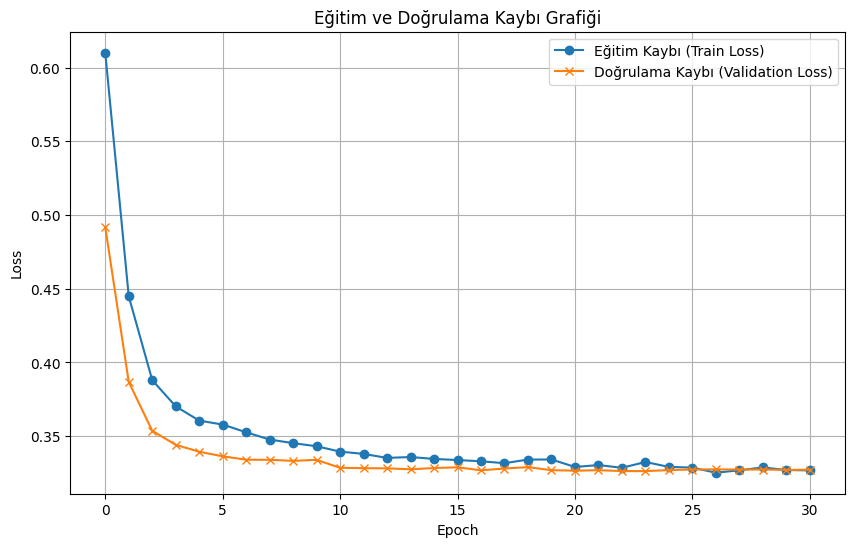

<ipython-input-3-046710c8b087>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_lstnet_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 15.04
Gün 2: 15.09
Gün 3: 14.92
Gün 4: 14.23
Gün 5: 14.17
Gün 6: 14.09
Gün 7: 14.00

Dew Point için tahminler:
Gün 1: 10.42
Gün 2: 10.55
Gün 3: 10.55
Gün 4: 10.10
Gün 5: 9.98
Gün 6: 9.71
Gün 7: 9.54

Humidity için tahminler:
Gün 1: 75.55
Gün 2: 76.03
Gün 3: 76.75
Gün 4: 77.79
Gün 5: 77.38
Gün 6: 76.72
Gün 7: 76.45

Wind Speed için tahminler:
Gün 1: 10.72
Gün 2: 9.41
Gün 3: 8.33
Gün 4: 8.05
Gün 5: 7.76
Gün 6: 7.68
Gün 7: 7.73

Pressure için tahminler:
Gün 1: 29.82
Gün 2: 29.79
Gün 3: 29.79
Gün 4: 29.80
Gün 5: 29.80
Gün 6: 29.80
Gün 7: 29.82


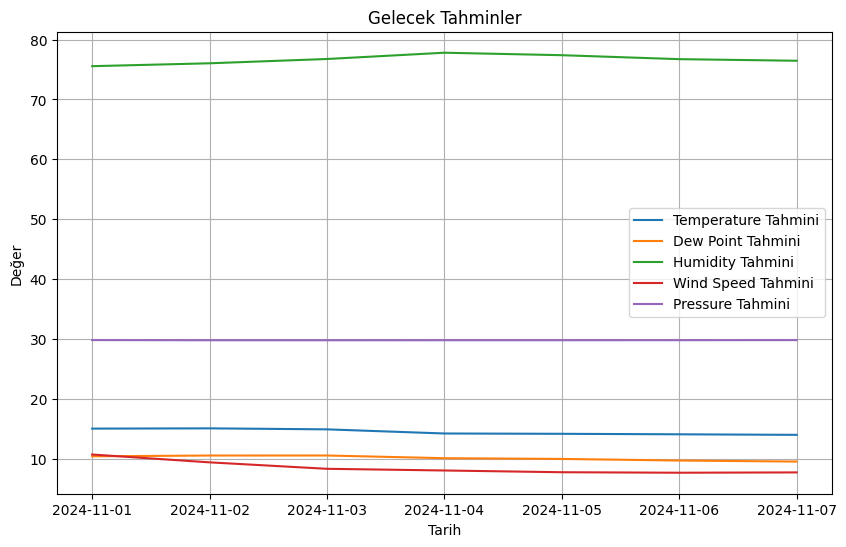

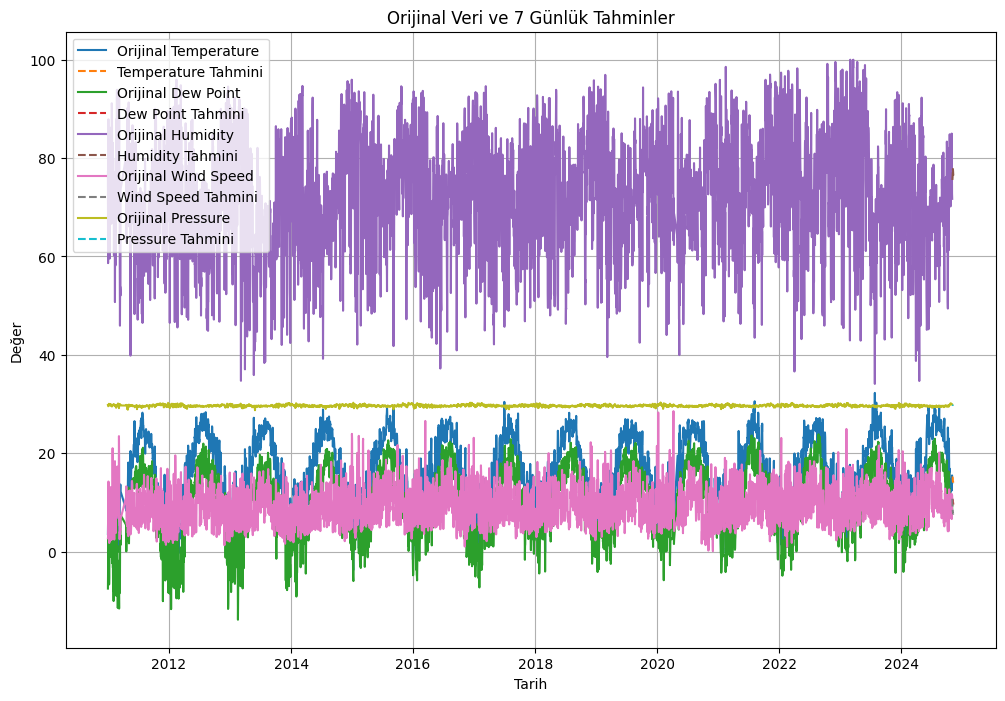

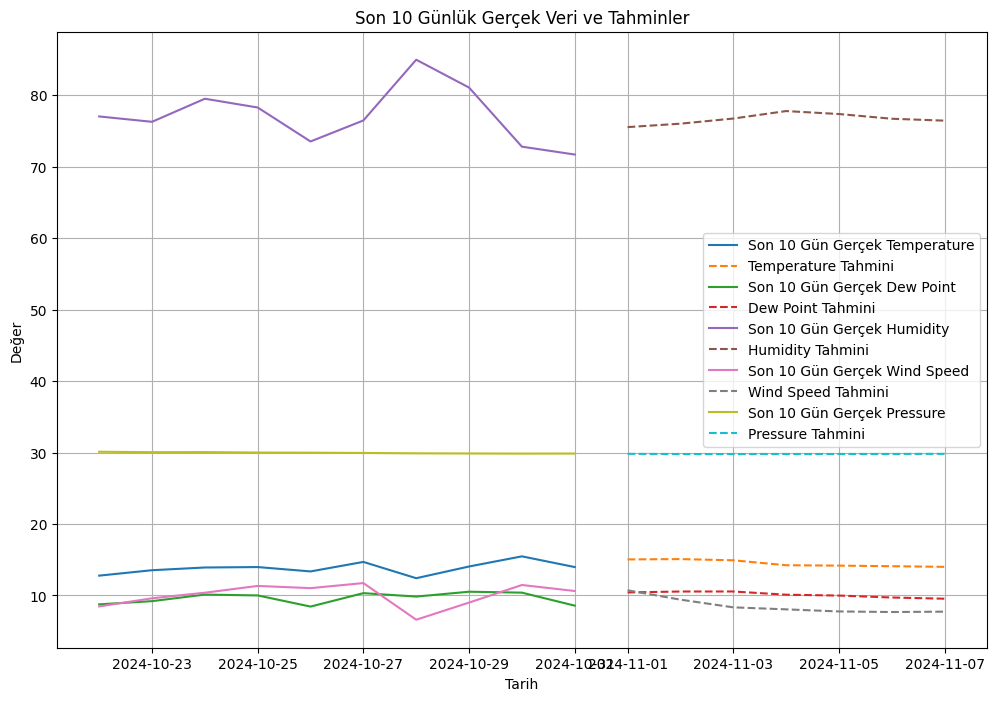

Training Time: 120.14 seconds
Inference Time: 0.02 seconds


In [ ]:
#LSTNET MODELİ
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time

# CSV dosyasını yükle
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')

# LSTNet Modeli
class LSTNet(nn.Module):
    def __init__(self, input_size, cnn_kernel, hidden_size, output_size, dropout=0.2):
        super(LSTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(cnn_kernel, input_size))
        self.relu = nn.ReLU()
        self.gru = nn.GRU(16, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, seq_len, input_size)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.squeeze(3).permute(0, 2, 1)  # (batch_size, seq_len, num_filters)
        x, _ = self.gru(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Son zaman adımının çıkışı
        return x

# Model parametreleri
input_size = 5  # Özellik sayısı
cnn_kernel = 6
hidden_size = 32
output_size = 5
learning_rate = 0.001
epochs = 35
patience = 7

# Modeli oluştur
model = LSTNet(input_size=input_size, cnn_kernel=cnn_kernel, hidden_size=hidden_size, output_size=output_size)

# Kayıp fonksiyonu ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lstnet_model.pth')  # En iyi modeli kaydet
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).numpy()

y_test_actual = y_test_tensor.numpy()

# Performans metriklerini hesaplama
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            current_sequence = np.vstack([current_sequence[1:], prediction])

    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

last_sequence = X_test[-1]
future_days = 7

model.load_state_dict(torch.load('best_lstnet_model.pth'))
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")


# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

Epoch 1/35 - Training Loss: 18.2072 - Validation Loss: 15.8574
Epoch 2/35 - Training Loss: 15.9729 - Validation Loss: 15.6611
Epoch 3/35 - Training Loss: 15.8146 - Validation Loss: 15.4276
Epoch 4/35 - Training Loss: 15.7232 - Validation Loss: 15.3289
Epoch 5/35 - Training Loss: 15.6076 - Validation Loss: 15.3297
Epoch 6/35 - Training Loss: 15.6941 - Validation Loss: 15.7231
Epoch 7/35 - Training Loss: 15.4967 - Validation Loss: 15.5350
Epoch 8/35 - Training Loss: 15.3872 - Validation Loss: 15.4097
Epoch 9/35 - Training Loss: 15.3823 - Validation Loss: 15.4908
Epoch 10/35 - Training Loss: 15.2916 - Validation Loss: 15.2321
Epoch 11/35 - Training Loss: 15.2741 - Validation Loss: 15.3111
Epoch 12/35 - Training Loss: 15.2444 - Validation Loss: 15.5873
Epoch 13/35 - Training Loss: 15.1617 - Validation Loss: 15.2896
Epoch 14/35 - Training Loss: 14.9989 - Validation Loss: 15.3516
Epoch 15/35 - Training Loss: 15.0483 - Validation Loss: 15.3925
Epoch 16/35 - Training Loss: 14.8823 - Validation

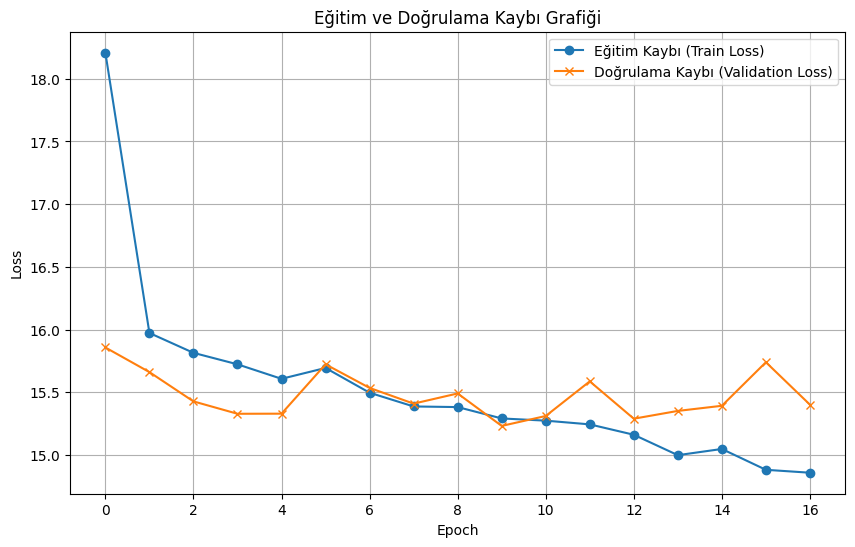

<ipython-input-13-d0b0174bd841>:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bayesian_reformer_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 14.45
Gün 2: 13.67
Gün 3: 13.02
Gün 4: 12.52
Gün 5: 12.17
Gün 6: 11.90
Gün 7: 11.70

Dew Point için tahminler:
Gün 1: 10.26
Gün 2: 10.00
Gün 3: 9.68
Gün 4: 9.36
Gün 5: 9.13
Gün 6: 8.91
Gün 7: 8.68

Humidity için tahminler:
Gün 1: 75.62
Gün 2: 77.69
Gün 3: 78.87
Gün 4: 79.60
Gün 5: 79.99
Gün 6: 80.09
Gün 7: 80.06

Wind Speed için tahminler:
Gün 1: 9.73
Gün 2: 8.78
Gün 3: 8.36
Gün 4: 8.26
Gün 5: 8.26
Gün 6: 8.31
Gün 7: 8.37

Pressure için tahminler:
Gün 1: 29.81
Gün 2: 29.80
Gün 3: 29.79
Gün 4: 29.79
Gün 5: 29.79
Gün 6: 29.79
Gün 7: 29.80


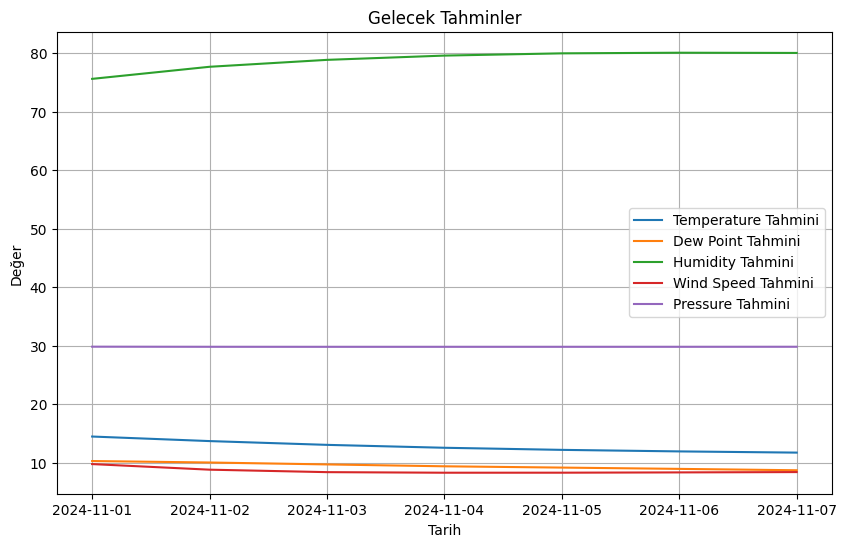

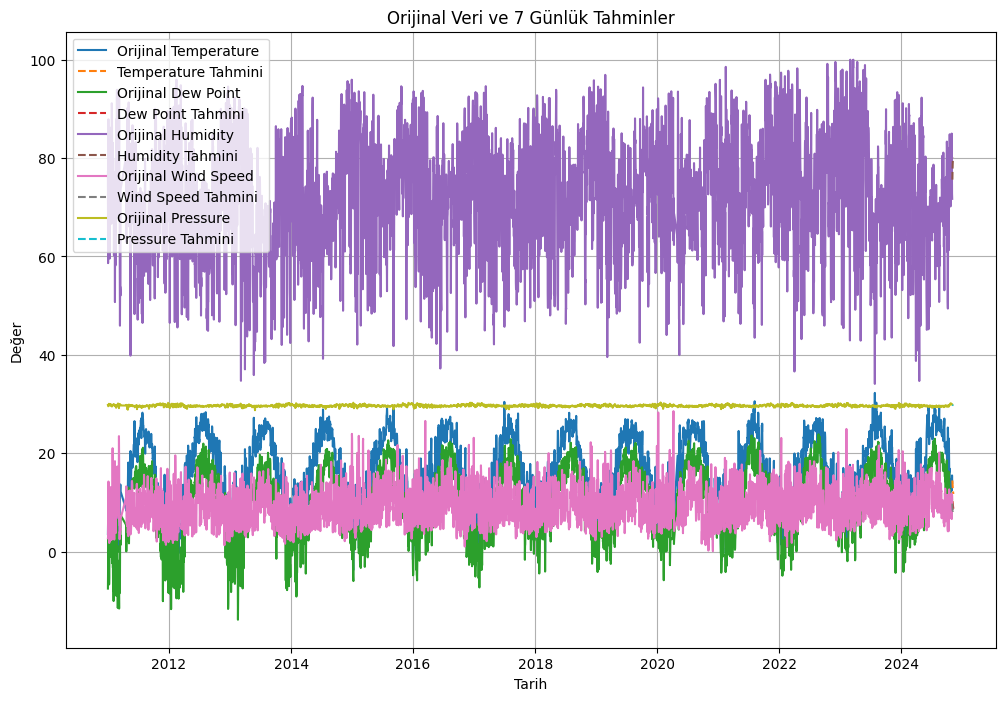

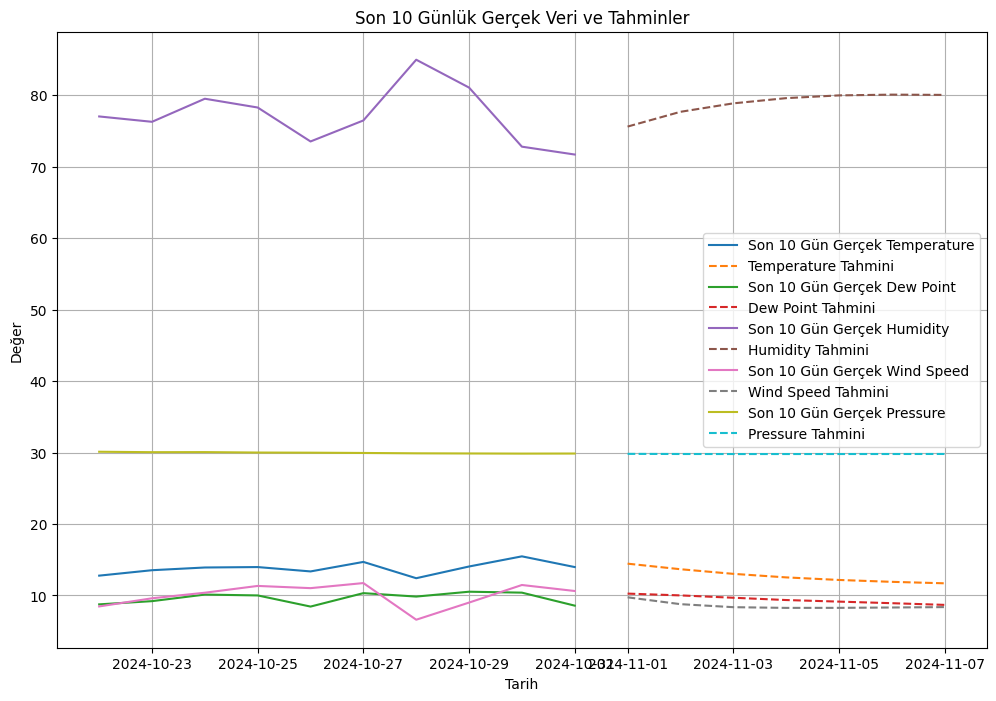

Training Time: 1206.08 seconds
Inference Time: 0.13 seconds


In [ ]:
#BAYESİAN REFORMER
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from reformer_pytorch import Reformer

# CSV dosyasını yükle
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')

# Bayesian Reformer Modeli
class BayesianReformerModel(PyroModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8):
        super(BayesianReformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.reformer = Reformer(
            dim=hidden_size,
            depth=num_layers,
            heads=num_heads,
            bucket_size=15,  # Bucket size
            causal=True      # Causal attention (useful for time series)
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_projection(x)  # Input projection
        x = self.reformer(x)          # Pass through the Reformer layer
        output = self.fc(x[:, -1, :]) # Output from the last time step
        # Here we use a normal distribution for the output, modeling uncertainty
        mean = output
        # We'll use a small fixed variance for simplicity, you can tune it
        variance = torch.ones_like(mean) * 0.1
        return dist.Normal(mean, variance)

# Model parametreleri
input_size = 5  # Özellik sayısı
hidden_size = 32
num_layers = 2
output_size = 5
learning_rate = 0.001
epochs = 35
num_heads = 4
patience = 7

# Modeli oluştur
model = BayesianReformerModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, num_heads=num_heads)

# Kayıp fonksiyonu ve optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        # Bayes'in yaklaşımını kullanalım
        output = model(inputs)
        loss = -output.log_prob(targets).mean()  # Negative log likelihood
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_output = model(val_inputs)
            val_loss = -val_output.log_prob(val_targets).mean()  # Negative log likelihood
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # En iyi modeli kaydet
        torch.save(model.state_dict(), 'best_bayesian_reformer_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()  # Modeli değerlendirme moduna geçirin
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).mean.numpy()  # Modelin test seti tahminlerini al

# Test setindeki gerçek değerler
y_test_actual = y_test_tensor.numpy()  # Test setinin gerçek değerlerini numpy array'e dönüştür

# Metriklerin hesaplanması
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).mean.squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            # Yeni tahminlerle sekansı güncelle
            current_sequence = np.vstack([current_sequence[1:], prediction])

    # Tahminleri orijinal ölçeğe geri döndür
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Tahmin için son sekansı al
last_sequence = X_test[-1]
future_days = 7  # Tahmin yapmak istediğiniz gün sayısı

# En iyi modeli yükle
model.load_state_dict(torch.load('best_bayesian_reformer_model.pth'))

# Tahminleri oluştur
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


Epoch 1/35 - Training Loss: 0.4903 - Validation Loss: 0.3744
Epoch 2/35 - Training Loss: 0.4319 - Validation Loss: 0.3789
Epoch 3/35 - Training Loss: 0.4118 - Validation Loss: 0.3559
Epoch 4/35 - Training Loss: 0.4151 - Validation Loss: 0.3698
Epoch 5/35 - Training Loss: 0.4047 - Validation Loss: 0.3535
Epoch 6/35 - Training Loss: 0.4093 - Validation Loss: 0.3634
Epoch 7/35 - Training Loss: 0.4073 - Validation Loss: 0.3546
Epoch 8/35 - Training Loss: 0.4032 - Validation Loss: 0.3483
Epoch 9/35 - Training Loss: 0.3962 - Validation Loss: 0.3494
Epoch 10/35 - Training Loss: 0.3968 - Validation Loss: 0.3516
Epoch 11/35 - Training Loss: 0.3909 - Validation Loss: 0.3435
Epoch 12/35 - Training Loss: 0.3879 - Validation Loss: 0.3414
Epoch 13/35 - Training Loss: 0.3861 - Validation Loss: 0.3439
Epoch 14/35 - Training Loss: 0.3860 - Validation Loss: 0.3419
Epoch 15/35 - Training Loss: 0.3846 - Validation Loss: 0.3398
Epoch 16/35 - Training Loss: 0.3853 - Validation Loss: 0.3443
Epoch 17/35 - Tra

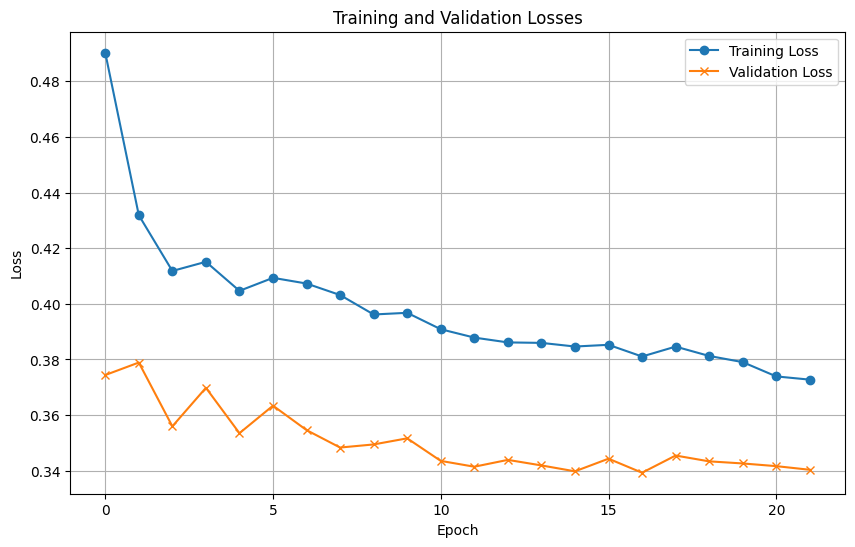

<ipython-input-2-20d1941ecfaa>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_autoformer_model.pth'))
<ipython-input-2-20d1941ecfa

MSE: 0.3404075503349304
MAE: 0.40983375906944275
RMSE: 0.5834445563504131
R2: 0.6616665124893188
MAPE: 2.004774332046509
Training Time: 487.60 seconds
Inference Time: 1.21 seconds

Temperature için tahminler:
Gün 1: 15.73
Gün 2: 16.08
Gün 3: 16.43
Gün 4: 16.75
Gün 5: 17.01
Gün 6: 17.15
Gün 7: 17.19

Dew Point için tahminler:
Gün 1: 11.14
Gün 2: 11.90
Gün 3: 12.43
Gün 4: 12.77
Gün 5: 12.98
Gün 6: 13.10
Gün 7: 13.13

Humidity için tahminler:
Gün 1: 75.87
Gün 2: 77.57
Gün 3: 78.40
Gün 4: 78.50
Gün 5: 78.36
Gün 6: 78.31
Gün 7: 78.27

Wind Speed için tahminler:
Gün 1: 10.61
Gün 2: 10.16
Gün 3: 9.91
Gün 4: 9.72
Gün 5: 9.56
Gün 6: 9.46
Gün 7: 9.39

Pressure için tahminler:
Gün 1: 29.81
Gün 2: 29.77
Gün 3: 29.74
Gün 4: 29.72
Gün 5: 29.70
Gün 6: 29.68
Gün 7: 29.67


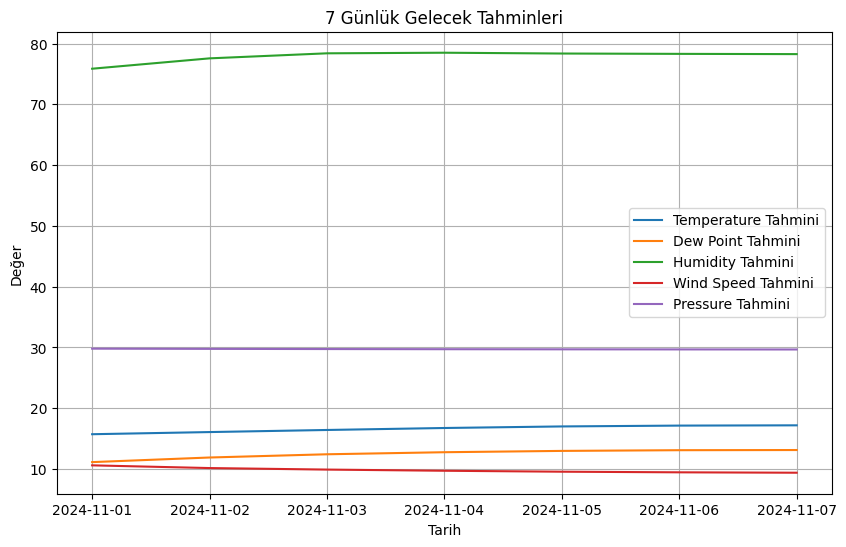

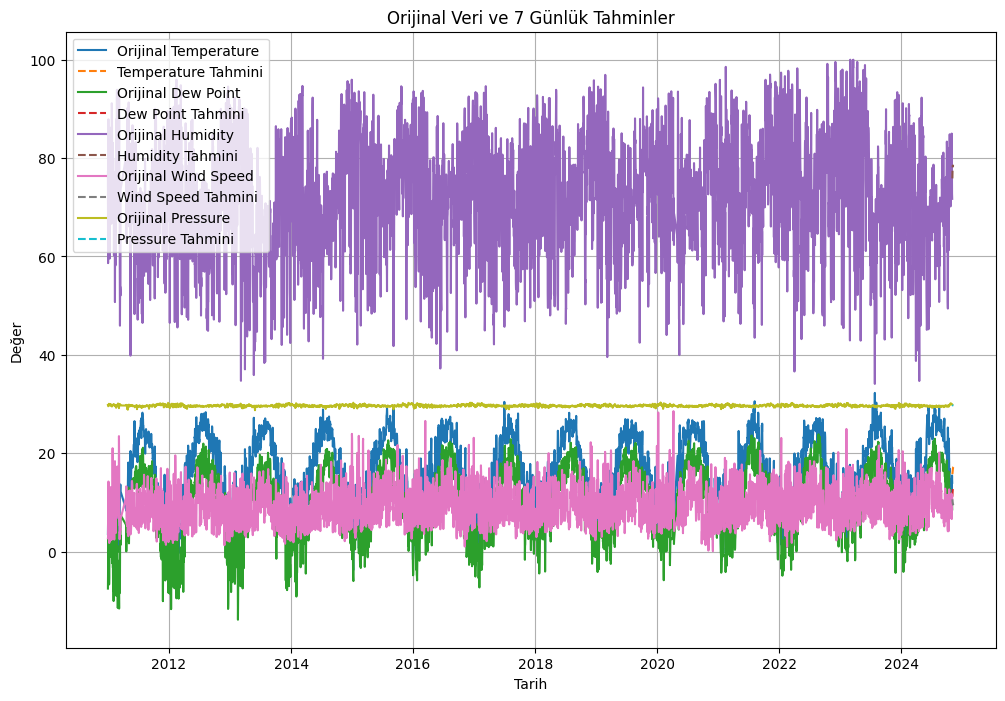

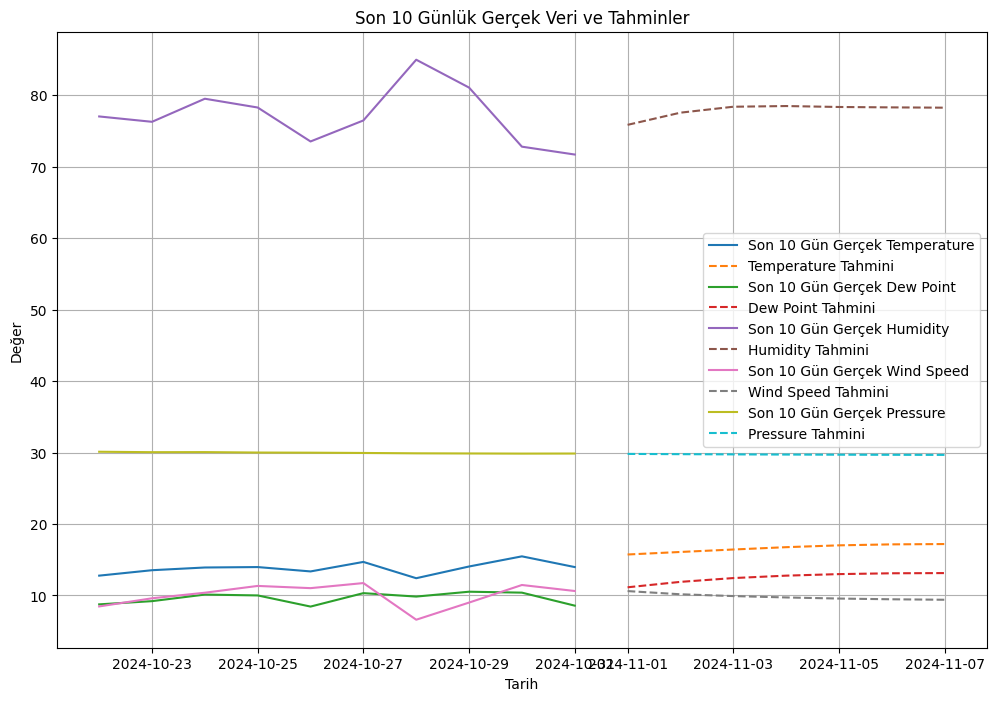

In [ ]:
#AUTOFORMER MODELİ KÜTÜPHANELİ OLANA EN YAKIN MANTIK
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time

# Auto-Correlation Mechanism
class AutoCorrelation(nn.Module):
    def __init__(self):
        super(AutoCorrelation, self).__init__()

    def forward(self, Q, K):
        Q_fft = torch.fft.fft(Q, dim=-1)
        K_fft = torch.fft.fft(K, dim=-1).conj()
        auto_corr = torch.fft.ifft(Q_fft * K_fft, dim=-1).real
        return auto_corr

# Advanced Temporal Decomposition Block
class AdvancedDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(AdvancedDecomposition, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        trend = self.moving_avg(x)
        seasonal = x - trend
        return trend, seasonal

# Autoformer Encoder
class AutoformerEncoder(nn.Module):
    def __init__(self, hidden_size, num_layers, num_heads):
        super(AutoformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Autoformer Decoder
class AutoformerDecoder(nn.Module):
    def __init__(self, hidden_size, num_layers, num_heads):
        super(AutoformerDecoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads) for _ in range(num_layers)
        ])

    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return x

# Autoformer Model
class AutoformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8, kernel_size=25):
        super(AutoformerModel, self).__init__()
        self.decomposition = AdvancedDecomposition(kernel_size=kernel_size)
        self.encoder = AutoformerEncoder(hidden_size, num_layers, num_heads)
        self.decoder = AutoformerDecoder(hidden_size, num_layers, num_heads)
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.output_projection = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x_enc, x_dec):
        # Decomposition
        trend_enc, seasonal_enc = self.decomposition(x_enc.permute(0, 2, 1))
        trend_dec, seasonal_dec = self.decomposition(x_dec.permute(0, 2, 1))

        # Encoder
        x_enc_proj = self.input_projection(seasonal_enc.permute(2, 0, 1))
        enc_output = self.encoder(x_enc_proj)
        enc_output = self.dropout(enc_output)

        # Decoder
        x_dec_proj = self.input_projection(seasonal_dec.permute(2, 0, 1))
        dec_output = self.decoder(x_dec_proj, enc_output)
        dec_output = self.dropout(dec_output)

        # Combine trend and seasonal outputs
        output = self.output_projection(dec_output[-1, :, :]) + trend_dec[:, -1, :]
        return output

# Model Parameters
input_size = 5
hidden_size = 32
num_layers = 2
output_size = 5
learning_rate = 0.001
epochs = 35
num_heads = 4
kernel_size = 25
patience = 5

# Initialize Model
model = AutoformerModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                        output_size=output_size, num_heads=num_heads, kernel_size=kernel_size)

# Criterion and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Load Data
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create Sequences
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Training Loop
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        decoder_inputs = inputs[:, -1:, :]
        optimizer.zero_grad()
        outputs = model(inputs, decoder_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_decoder_inputs = val_inputs[:, -1:, :]
            val_outputs = model(val_inputs, val_decoder_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_autoformer_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Plot Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

# Load Best Model
model.load_state_dict(torch.load('best_autoformer_model.pth'))


# Çıkarım ve metrik hesaplama
start_inference_time = time.time()
model.load_state_dict(torch.load('best_autoformer_model.pth'))
model.eval()
with torch.no_grad():
    decoder_inputs = X_test_tensor[:, -1:, :]
    y_pred = model(X_test_tensor, decoder_inputs)

y_pred = y_pred.numpy()
y_test_flat = y_test_tensor.numpy()
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

mse = mean_squared_error(y_test_flat, y_pred)
mae = mean_absolute_error(y_test_flat, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, y_pred)
mape = mean_absolute_percentage_error(y_test_flat, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAPE: {mape}")

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

# Gelecek tahminler
future_days = 7
last_sequence = X_test_tensor[-1].numpy()
future_predictions = []
model.eval()
current_sequence = last_sequence

for _ in range(future_days):
    with torch.no_grad():
        current_sequence_tensor = torch.Tensor(current_sequence).unsqueeze(0)
        decoder_input = current_sequence_tensor[:, -1:, :]
        next_prediction = model(current_sequence_tensor, decoder_input).squeeze(0).numpy()
        future_predictions.append(next_prediction)
        current_sequence = np.vstack([current_sequence[1:], next_prediction])

future_predictions = scaler.inverse_transform(future_predictions)

# Gelecek tahminleri düzenli bir şekilde yazdırma
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]

plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('7 Günlük Gelecek Tahminleri')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

Epoch 1/35 - Training Loss: 0.4041 - Validation Loss: 0.3410
Epoch 2/35 - Training Loss: 0.3465 - Validation Loss: 0.3417
Epoch 3/35 - Training Loss: 0.3424 - Validation Loss: 0.3397
Epoch 4/35 - Training Loss: 0.3414 - Validation Loss: 0.3384
Epoch 5/35 - Training Loss: 0.3413 - Validation Loss: 0.3333
Epoch 6/35 - Training Loss: 0.3383 - Validation Loss: 0.3311
Epoch 7/35 - Training Loss: 0.3363 - Validation Loss: 0.3325
Epoch 8/35 - Training Loss: 0.3347 - Validation Loss: 0.3351
Epoch 9/35 - Training Loss: 0.3341 - Validation Loss: 0.3345
Epoch 10/35 - Training Loss: 0.3336 - Validation Loss: 0.3371
Epoch 11/35 - Training Loss: 0.3265 - Validation Loss: 0.3328
Epoch 12/35 - Training Loss: 0.3261 - Validation Loss: 0.3347
Epoch 13/35 - Training Loss: 0.3249 - Validation Loss: 0.3330
Early stopping triggered.
=== Test Seti Performansı ===
MSE: 0.3340
MAE: 0.4007
RMSE: 0.5779
R²: 0.6683
MAPE: 2.0910


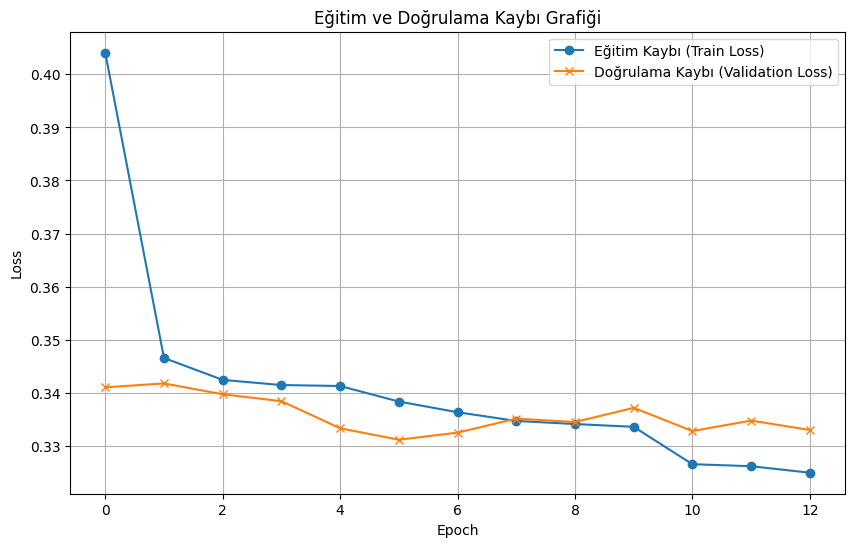

<ipython-input-25-035270974a04>:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_reformer_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 15.70
Gün 2: 15.98
Gün 3: 16.20
Gün 4: 16.29
Gün 5: 16.32
Gün 6: 16.19
Gün 7: 16.04

Dew Point için tahminler:
Gün 1: 11.54
Gün 2: 12.31
Gün 3: 12.70
Gün 4: 12.94
Gün 5: 13.03
Gün 6: 12.92
Gün 7: 12.73

Humidity için tahminler:
Gün 1: 76.71
Gün 2: 79.54
Gün 3: 81.35
Gün 4: 82.44
Gün 5: 83.10
Gün 6: 83.36
Gün 7: 83.28

Wind Speed için tahminler:
Gün 1: 9.59
Gün 2: 9.00
Gün 3: 8.99
Gün 4: 9.16
Gün 5: 9.39
Gün 6: 9.56
Gün 7: 9.65

Pressure için tahminler:
Gün 1: 29.81
Gün 2: 29.78
Gün 3: 29.75
Gün 4: 29.73
Gün 5: 29.72
Gün 6: 29.71
Gün 7: 29.71


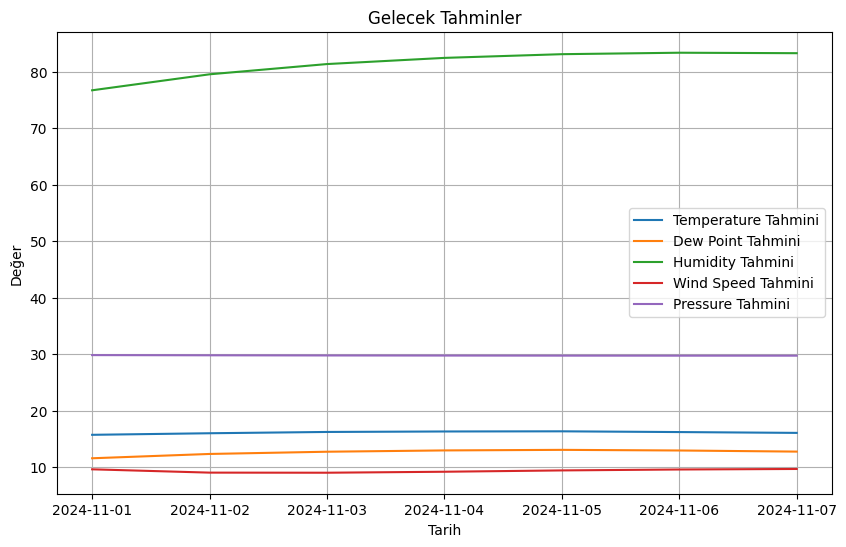

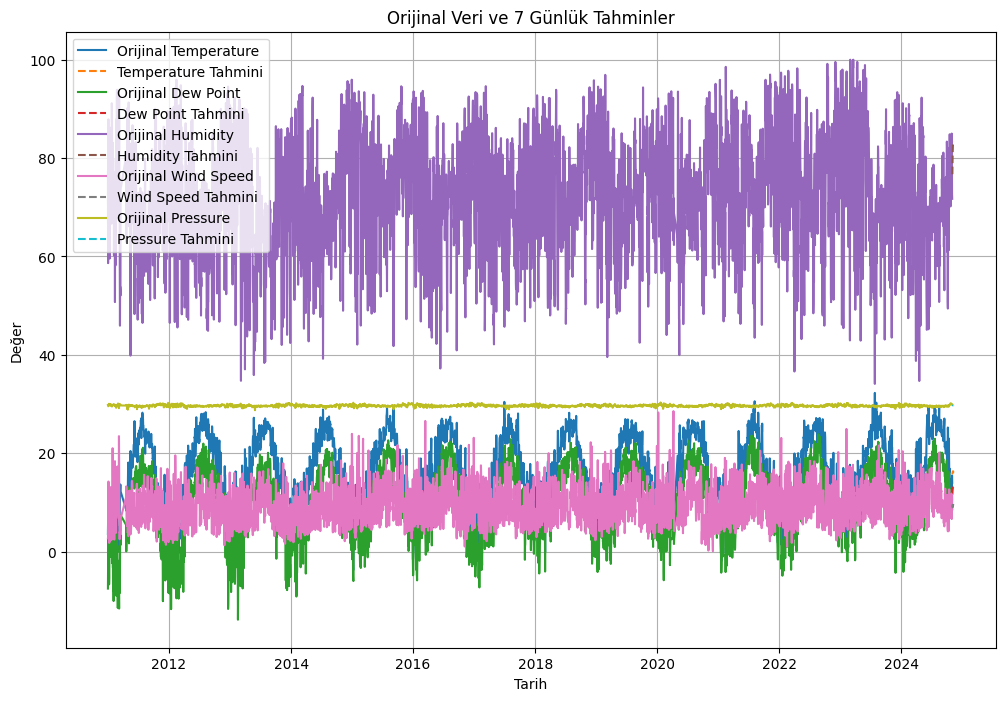

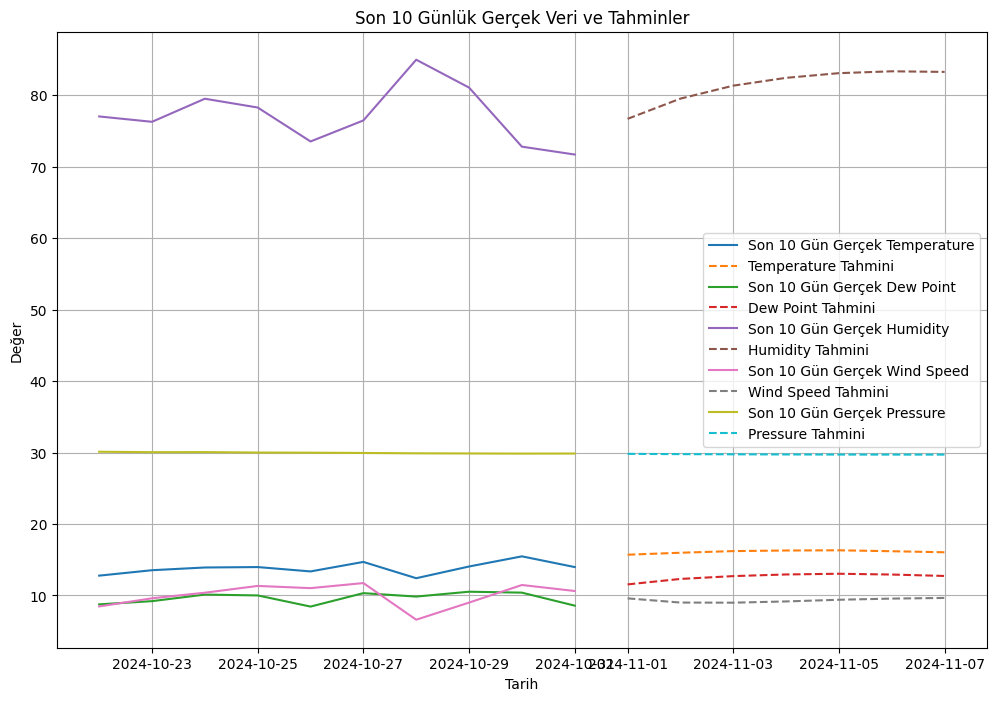

Training Time: 834.09 seconds
Inference Time: 0.12 seconds


In [ ]:
#REFORMER MODELİ
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time
from reformer_pytorch import Reformer

# CSV dosyasını yükle
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')

# Reformer Modeli
class ReformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8):
        super(ReformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.reformer = Reformer(
            dim=hidden_size,
            depth=num_layers,
            heads=num_heads,
            bucket_size=15,  # Bucket boyutu
            causal=True  # Causal attention (zaman serisi için)
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_projection(x)  # Giriş projeksiyonu
        x = self.reformer(x)  # Reformer katmanından geçir
        output = self.fc(x[:, -1, :])  # Son zaman adımındaki tahmin
        return output

# Model parametreleri
input_size = 5  # Özellik sayısı
hidden_size = 32
num_layers = 2
output_size = 5
learning_rate = 0.001
epochs = 35
num_heads = 4
patience = 7

# Modeli oluştur
model = ReformerModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, num_heads=num_heads)

# Kayıp fonksiyonu ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_reformer_model.pth')  # En iyi modeli kaydet
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()  # Modeli değerlendirme moduna geçirin
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).numpy()  # Modelin test seti tahminlerini al

# Test setindeki gerçek değerler
y_test_actual = y_test_tensor.numpy()  # Test setinin gerçek değerlerini numpy array'e dönüştür

# Metriklerin hesaplanması
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            # Yeni tahminlerle sekansı güncelle
            current_sequence = np.vstack([current_sequence[1:], prediction])

    # Tahminleri orijinal ölçeğe geri döndür
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Tahmin için son sekansı al
last_sequence = X_test[-1]
future_days = 7  # Tahmin yapmak istediğiniz gün sayısı

# En iyi modeli yükle
model.load_state_dict(torch.load('best_reformer_model.pth'))

# Tahminleri oluştur
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

Modeldeki parametre sayısı: 26979


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 288    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 7.2 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



=== Eğitim Tamamlandı, Performans Metrikleri Hesaplanıyor ===


<ipython-input-46-067edc60b01a>:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.cat([torch.tensor(pred) for pred in val_predictions], dim=0)


Target            MSE      MAE     RMSE       R²         MAPE
-----------  --------  -------  -------  -------  -----------
Temperature   73.2374   6.9171   8.5579  -0.3612     416.5527
Dew Point     62.7276   6.3995   7.9201  -0.3598  176345.8281
Humidity     177.1913  10.7457  13.3113  -0.3611       0.1560
Wind Speed    19.0168   3.5230   4.3608  -0.3645       0.7788
Pressure       0.0459   0.1732   0.2142  -0.3638       0.0058
Average       66.4438   5.5517   6.8729  -0.3621   35352.6643
Training Time: 1036.72 seconds
Inference Time: 21.17 seconds


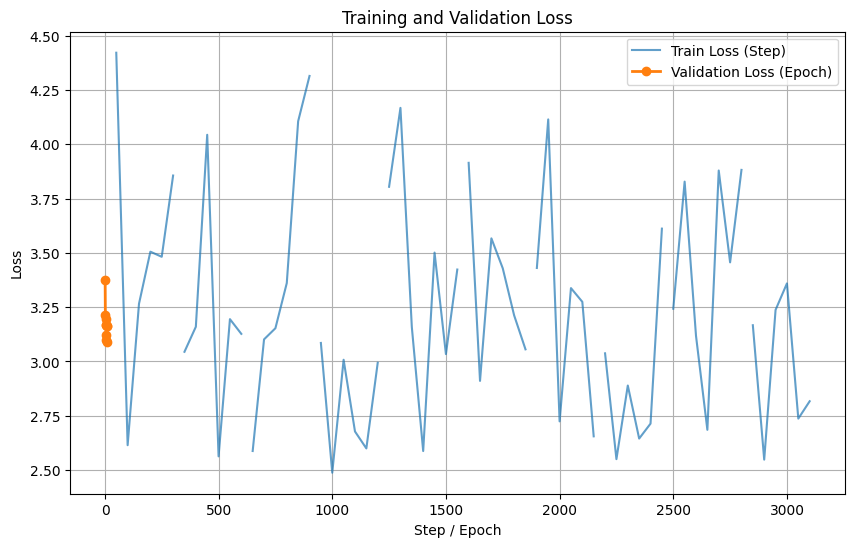

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:107: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([16, 7, 1, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


predictions_squeezed shape: torch.Size([4995, 7, 7])


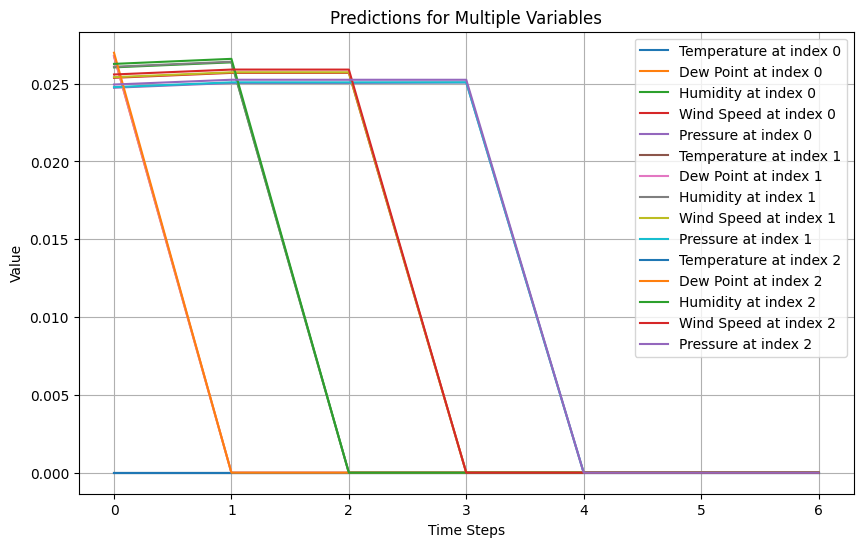

Gelecek tahminler (yeniden ölçeklendirilmiş):
[[ 3.7333348 -1.1967278 53.357834   3.11731   29.352367 ]
 [ 3.8751328 -0.1387186 53.45017    3.1190324 29.352566 ]
 [ 3.6735566 -1.1995249 53.346542   3.2218604 29.354013 ]
 ...
 [19.128437  15.6130085 81.347664  12.224007  29.78527  ]
 [19.872541  13.273804  77.52637   12.372676  29.802994 ]
 [21.609642  15.318361  80.27455   11.399853  29.744354 ]]


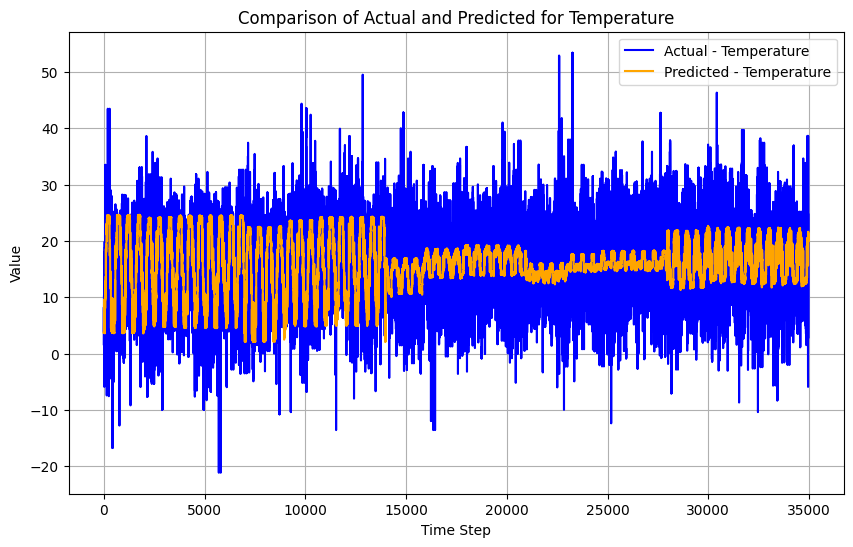

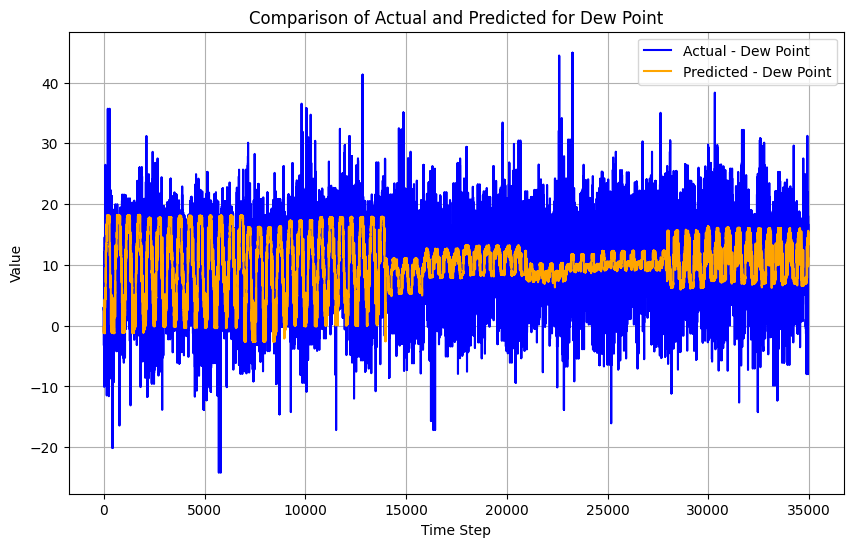

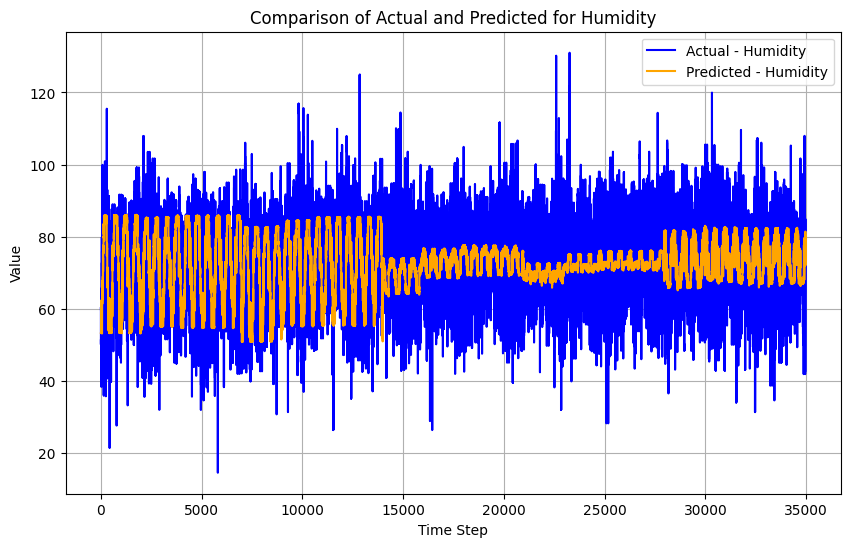

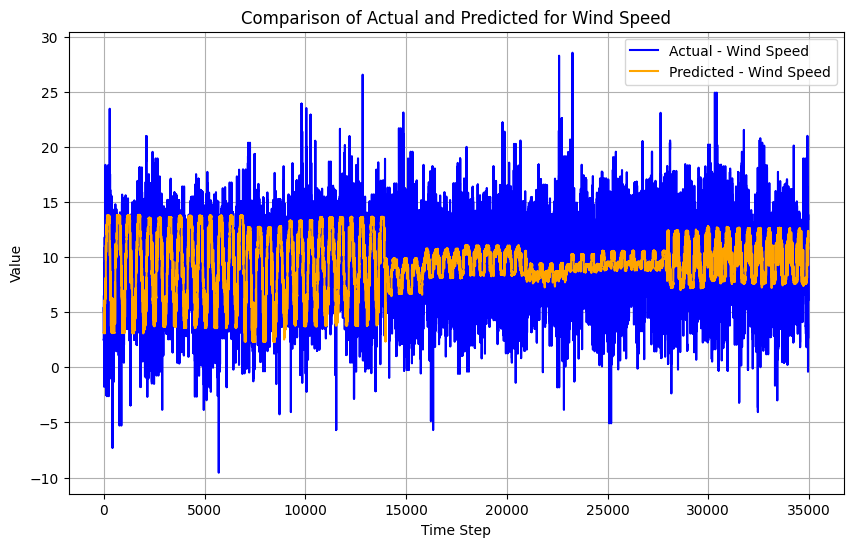

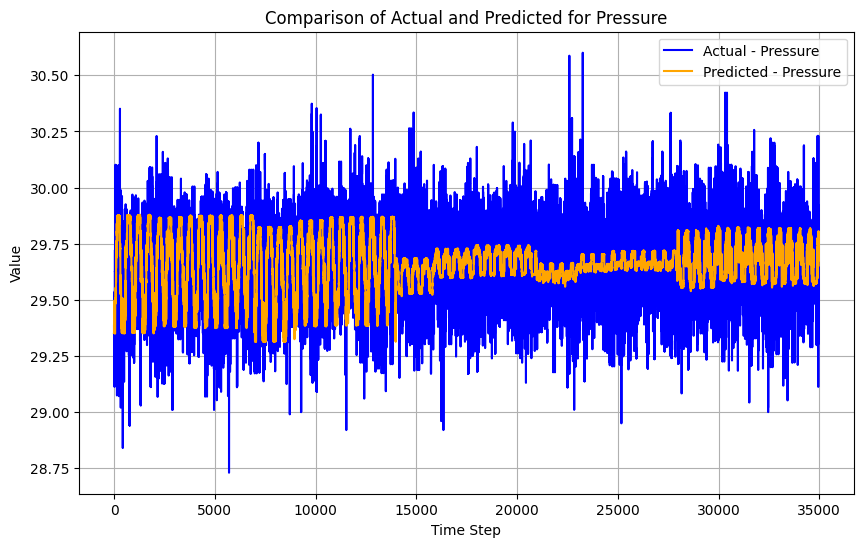

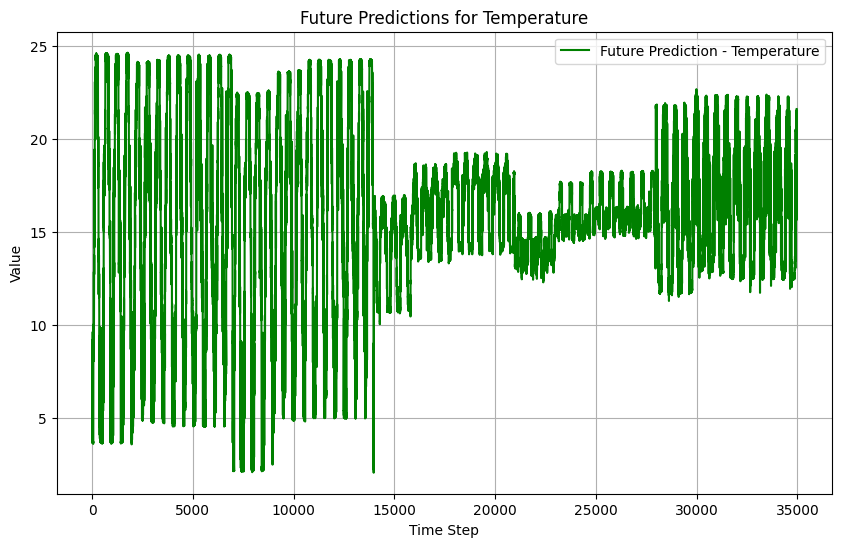

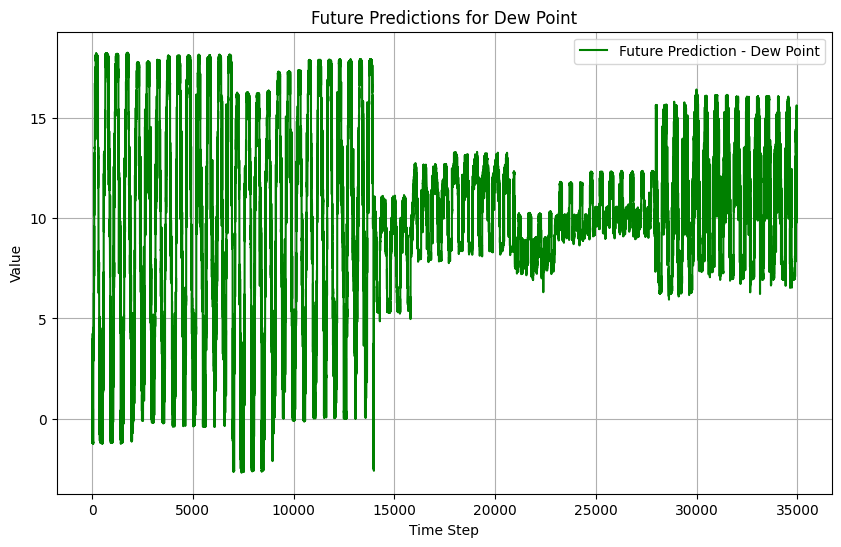

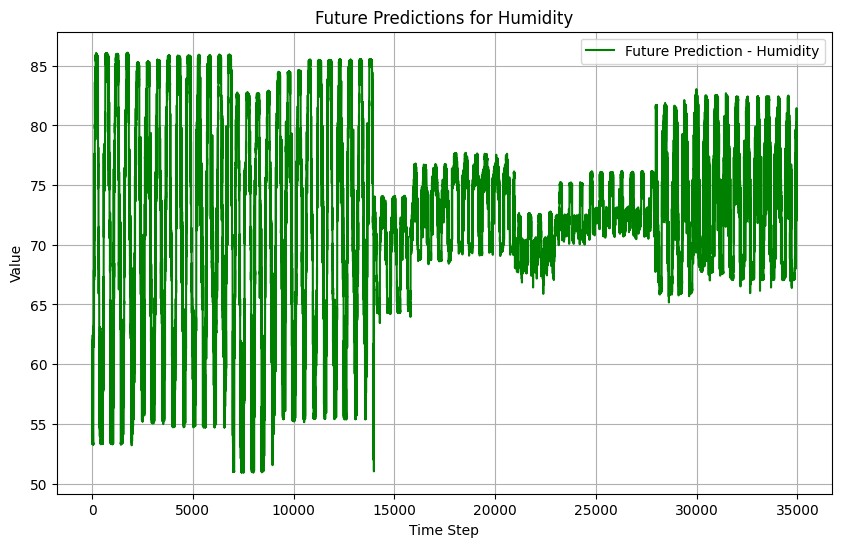

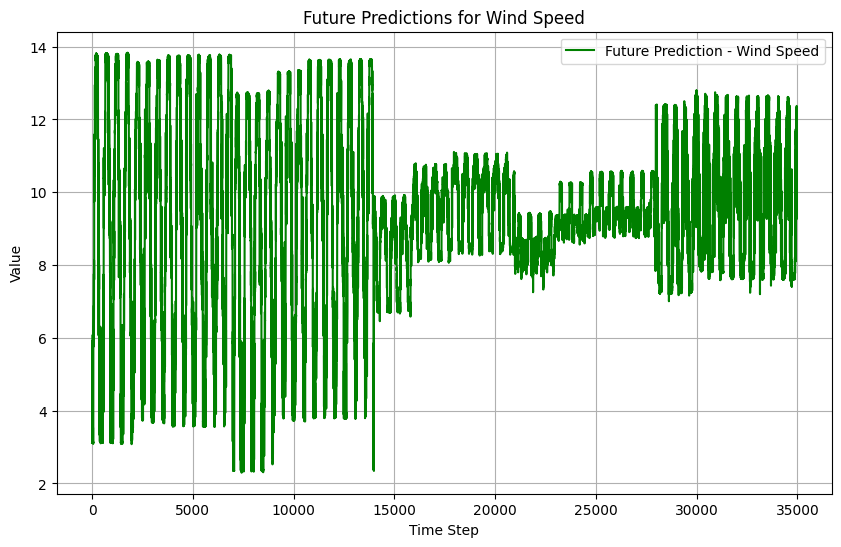

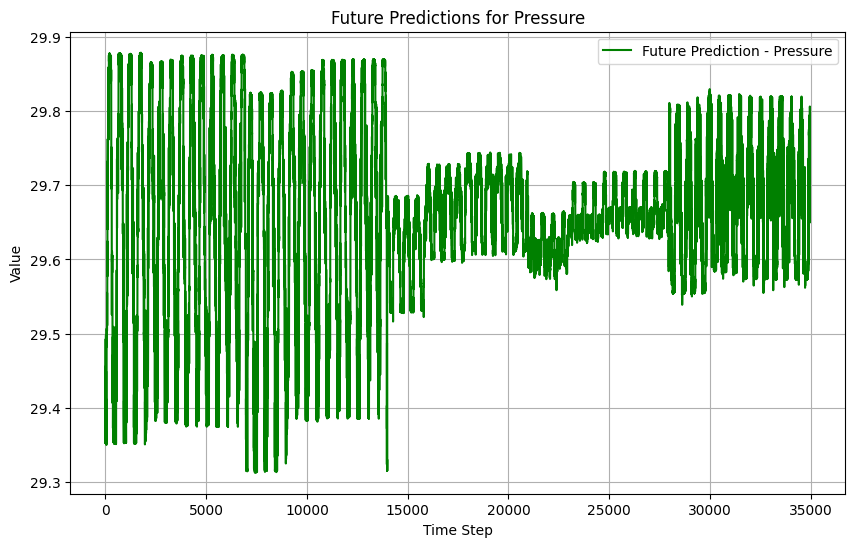

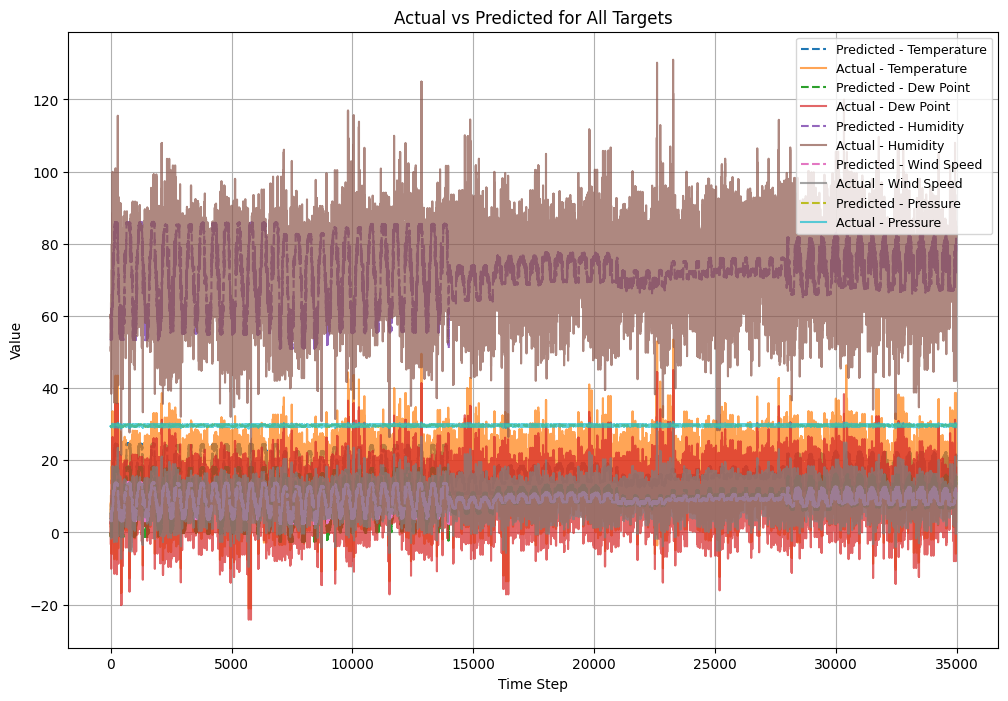

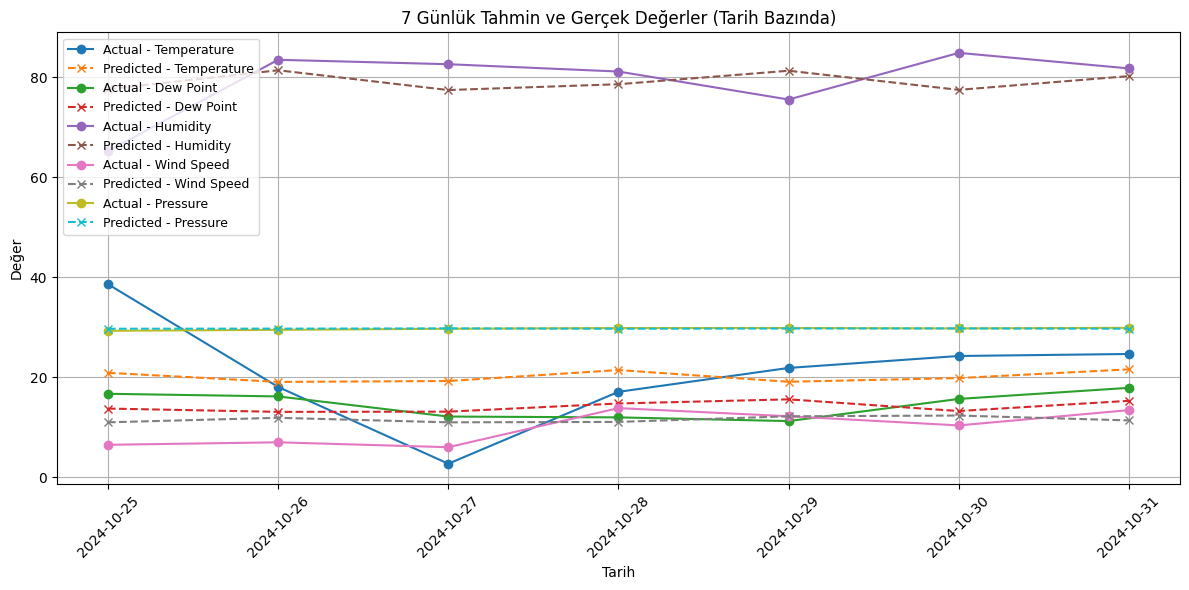

In [ ]:
#TFT MODELİ TÜM DEĞERLER
import pandas as pd
import numpy as np
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
import time

# 1. Veriyi Yükleme ve Hazırlama
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')
df = df[['Date', 'Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].copy()
df['time_idx'] = range(len(df))
df['time_idx'] = df['time_idx'].astype('int64')
df['group_id'] = 0  # Sabit grup kimliği

# Tüm sayısal sütunlar hedef olarak ayarlanır
target = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']
time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = target

# 2. Ölçeklendirme
data = df[['time_idx', 'group_id'] + target].copy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[target])
data[target] = scaled_features

from pytorch_forecasting.data.encoders import GroupNormalizer, MultiNormalizer

max_encoder_length = 30  # Girdi uzunluğu
max_prediction_length = 7  # Tahmin uzunluğu


# TemporalFusionTransformer Veri Seti
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target=target,
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=MultiNormalizer(
        [GroupNormalizer(groups=["group_id"]) for _ in target]
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

train_dataloader = dataset.to_dataloader(train=True, batch_size=16, num_workers=0)
val_dataloader = dataset.to_dataloader(train=False, batch_size=16, num_workers=0)

# TemporalFusionTransformer Modeli
tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[1] * len(target),  # Her hedef değişken için ayrı bir çıktı boyutu
    loss=RMSE(reduction="mean"),
    reduce_on_plateau_patience=4,
)
print(f"Modeldeki parametre sayısı: {tft.size()}")

# 5. Eğitim Ayarları ve Trainer
early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")
logger = CSVLogger("logs", name="tft-training")

trainer = Trainer(
    max_epochs=10,
    accelerator="cpu",  # GPU kullanımını aktif etmek için "gpu" yapabilirsiniz
    gradient_clip_val=0.1,
    logger=logger,
    callbacks=[early_stop_callback],
)

# Eğitim süresini ölçme
start_time = time.time()
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
training_time = time.time() - start_time

# 6. Eğitim ve doğrulama sonrası metrikler
print("\n=== Eğitim Tamamlandı, Performans Metrikleri Hesaplanıyor ===")

# Doğrulama seti tahminlerini yapmak
start_inference_time = time.time()  # Inferans süresi başlangıcı
val_predictions = tft.predict(val_dataloader)
inference_time = time.time() - start_inference_time  # Inferans süresi hesaplama

# Val actuals için doğru yapıyı oluşturma
val_actuals = torch.cat(
    [torch.cat(y[0], dim=0) for x, y in iter(val_dataloader) if y[0] is not None],
    dim=0
).numpy()

# Tahminler
val_predictions = tft.predict(val_dataloader)

# Eğer `val_predictions` bir liste ise tensöre dönüştür
if isinstance(val_predictions, list):
    val_predictions = torch.cat([torch.tensor(pred) for pred in val_predictions], dim=0)

# Ölçeklendirmeyi geri alma
actuals_rescaled = scaler.inverse_transform(val_actuals.reshape(-1, len(target)))
predicted_values_rescaled = scaler.inverse_transform(val_predictions.numpy().reshape(-1, len(target)))
# Performans Metriklerini Hesaplama
from tabulate import tabulate  # Sonuçları tablo olarak göstermek için

metrics_table = []

for i, col in enumerate(target):
    # Hedef değişken için metrikleri hesaplama
    mse = mean_squared_error(actuals_rescaled[:, i], predicted_values_rescaled[:, i])
    mae = mean_absolute_error(actuals_rescaled[:, i], predicted_values_rescaled[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals_rescaled[:, i], predicted_values_rescaled[:, i])
    mape = mean_absolute_percentage_error(actuals_rescaled[:, i], predicted_values_rescaled[:, i])

    # Sonuçları tabloya ekleme
    metrics_table.append([col, mse, mae, rmse, r2, mape])

# Ortalama Metrikler
average_mse = np.mean([row[1] for row in metrics_table])
average_mae = np.mean([row[2] for row in metrics_table])
average_rmse = np.mean([row[3] for row in metrics_table])
average_r2 = np.mean([row[4] for row in metrics_table])
average_mape = np.mean([row[5] for row in metrics_table])

metrics_table.append(["Average", average_mse, average_mae, average_rmse, average_r2, average_mape])

# Tabloyu Görselleştirme
headers = ["Target", "MSE", "MAE", "RMSE", "R²", "MAPE"]
print(tabulate(metrics_table, headers=headers, floatfmt=".4f"))


print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


# Loss Grafiği Oluşturma
log_path = logger.log_dir + "/metrics.csv"
metrics_df = pd.read_csv(log_path)

plt.figure(figsize=(10, 6))

# Train loss çizimi (step bazında)
if "train_loss_step" in metrics_df.columns:
    plt.plot(metrics_df["step"], metrics_df["train_loss_step"], label="Train Loss (Step)", alpha=0.7)

# Validation loss çizimi (epoch bazında)
if "val_loss" in metrics_df.columns:
    val_loss_data = metrics_df.dropna(subset=["val_loss"])
    plt.plot(val_loss_data["epoch"], val_loss_data["val_loss"], label="Validation Loss (Epoch)", linewidth=2, marker='o')

plt.xlabel("Step / Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Tahmin ve Görselleştirme
predictions_and_x = tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions = predictions_and_x.output
x = predictions_and_x.x

# `raw_predictions` içindeki doğru öğeyi seçme
if isinstance(raw_predictions, tuple):
    predictions = raw_predictions[2]  # Ana tahminlerin bulunduğu öğe

# predictions_squeezed boyutlarını kontrol etme
predictions_squeezed = predictions.squeeze(2)  # Üçüncü ekseni sıkıştır
print(f"predictions_squeezed shape: {predictions_squeezed.shape}")

# Görselleştirme - Tek bir grafik üzerinde tüm tahminler
plt.figure(figsize=(10, 6))  # Grafik boyutunu ayarlıyoruz

for idx in range(3):  # İlk 3 örnek için
    for i, col in enumerate(target):
        try:
            # predictions_squeezed[idx, i, :] ile doğru veriyi alıyoruz ve numpy formatına çeviriyoruz
            prediction_data = predictions_squeezed[idx, i, :].cpu().numpy()  # PyTorch tensor ise numpy'ye dönüştür
            # Her hedef değişken için çizim ekliyoruz
            plt.plot(prediction_data, label=f"{col} at index {idx}")
        except Exception as e:
            print(f"Error while plotting for index {idx}, column {col}: {e}")

# Grafik başlık ve etiketlerini ekliyoruz
plt.title("Predictions for Multiple Variables")
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()  # Etiketleri gösteriyoruz
plt.grid(True)  # Izgara çizgilerini ekliyoruz
plt.show()


# Gelecek Tahminleri
future_predictions = tft.predict(val_dataloader, mode="prediction")

# Eğer future_predictions bir liste ise tensöre dönüştür
if isinstance(future_predictions, list):
    future_predictions = torch.cat([pred.clone().detach() for pred in future_predictions], dim=0)

# Ölçeklendirmeyi geri alma
future_predictions_rescaled = scaler.inverse_transform(future_predictions.numpy().reshape(-1, len(target)))

print("Gelecek tahminler (yeniden ölçeklendirilmiş):")
print(future_predictions_rescaled)

# 8. Tahminlerin Görselleştirilmesi
for i, col in enumerate(target):
    plt.figure(figsize=(10, 6))
    plt.plot(actuals_rescaled[:, i], label=f"Actual - {col}", color="blue")
    plt.plot(predicted_values_rescaled[:, i], label=f"Predicted - {col}", color="orange")
    plt.title(f"Comparison of Actual and Predicted for {col}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# 9. Gelecek Tahminleri
future_predictions = tft.predict(val_dataloader, mode="prediction")
if isinstance(future_predictions, list):
    future_predictions = torch.cat([pred.clone().detach() for pred in future_predictions], dim=0)

future_predictions_rescaled = scaler.inverse_transform(future_predictions.numpy().reshape(-1, len(target)))

# Gelecek Tahminleri Görselleştirme
future_index = range(len(future_predictions_rescaled))
for i, col in enumerate(target):
    plt.figure(figsize=(10, 6))
    plt.plot(future_index, future_predictions_rescaled[:, i], label=f"Future Prediction - {col}", color="green")
    plt.title(f"Future Predictions for {col}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Tüm tahminler ve gerçek değerleri tek bir grafik üzerinde gösterme
plt.figure(figsize=(12, 8))  # Grafik boyutunu ayarla

for i, col in enumerate(target):
    plt.plot(
        range(len(predicted_values_rescaled[:, i])),
        predicted_values_rescaled[:, i],
        label=f"Predicted - {col}",
        linestyle='--'
    )
    plt.plot(
        range(len(actuals_rescaled[:, i])),
        actuals_rescaled[:, i],
        label=f"Actual - {col}",
        alpha=0.7
    )

plt.title("Actual vs Predicted for All Targets")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend(loc="upper right", fontsize=9)  # Her hedef için etiketi göster
plt.grid(True)
plt.show()

# Doğrulama veri setindeki tarihleri alalım
dates = df["Date"].iloc[-len(actuals_rescaled):]  # Doğrulama setine denk gelen tarihler

# 7 günlük tahmin ve gerçek değerleri çizme
plt.figure(figsize=(12, 6))

for i, col in enumerate(target):
    # Son 7 gün için tahmin ve gerçek değerleri al
    last_7_actuals = actuals_rescaled[-7:, i]
    last_7_predictions = predicted_values_rescaled[-7:, i]
    last_7_dates = dates.iloc[-7:]

    # Gerçek değerleri çiz
    plt.plot(last_7_dates, last_7_actuals, label=f"Actual - {col}", marker="o", linestyle="-")
    # Tahminleri çiz
    plt.plot(last_7_dates, last_7_predictions, label=f"Predicted - {col}", marker="x", linestyle="--")

plt.title("7 Günlük Tahmin ve Gerçek Değerler (Tarih Bazında)")
plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.legend(loc="upper left", fontsize=9)
plt.xticks(rotation=45)  # Tarih etiketlerini döndür
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#TFT TEST SETİ PERFORMANS DEĞERLENDİRMESİ
# Test veri seti oluşturma
test_dataset = dataset.from_dataset(dataset, data=data.iloc[-len(test_data):])
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=16, num_workers=0)

# Test Seti Üzerinde Performans Hesaplaması
print("\n=== Test Seti Üzerinde Performans Metrikleri Hesaplanıyor ===")

# Test seti tahminlerini yapmak
test_predictions = tft.predict(test_dataloader)

# Eğer test_predictions bir liste ise tensöre dönüştür
if isinstance(test_predictions, list):
    test_predictions = torch.cat([torch.tensor(pred) for pred in test_predictions], dim=0)

# Test actuals için doğru yapıyı oluşturma
test_actuals = torch.cat(
    [torch.cat(y[0], dim=0) for x, y in iter(test_dataloader) if y[0] is not None],
    dim=0
).numpy()

# Ölçeklendirmeyi geri alma
test_actuals_rescaled = scaler.inverse_transform(test_actuals.reshape(-1, len(target)))
test_predictions_rescaled = scaler.inverse_transform(test_predictions.numpy().reshape(-1, len(target)))

# Performans Metriklerini Hesaplama ve Yazdırma
metrics_table = []
for i, col in enumerate(target):
    mse = mean_squared_error(test_actuals_rescaled[:, i], test_predictions_rescaled[:, i])
    mae = mean_absolute_error(test_actuals_rescaled[:, i], test_predictions_rescaled[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(test_actuals_rescaled[:, i], test_predictions_rescaled[:, i])
    mape = mean_absolute_percentage_error(test_actuals_rescaled[:, i], test_predictions_rescaled[:, i])
    metrics_table.append([col, mse, mae, rmse, r2, mape])

# Performans metriklerini tablo formatında yazdırma
from tabulate import tabulate
headers = ["Target", "MSE", "MAE", "RMSE", "R²", "MAPE"]
print(tabulate(metrics_table, headers=headers, floatfmt=".4f"))

# Ortalama Metrikler
average_mse = np.mean([row[1] for row in metrics_table])
average_mae = np.mean([row[2] for row in metrics_table])
average_rmse = np.mean([row[3] for row in metrics_table])
average_r2 = np.mean([row[4] for row in metrics_table])
average_mape = np.mean([row[5] for row in metrics_table])

print("\n=== Test Seti Ortalama Performans Metrikleri ===")
print(f"Ortalama MSE: {average_mse:.4f}")
print(f"Ortalama MAE: {average_mae:.4f}")
print(f"Ortalama RMSE: {average_rmse:.4f}")
print(f"Ortalama R²: {average_r2:.4f}")
print(f"Ortalama MAPE: {average_mape:.4f}")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Test Seti Üzerinde Performans Metrikleri Hesaplanıyor ===


<ipython-input-43-d5bdebfa639d>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.cat([torch.tensor(pred) for pred in test_predictions], dim=0)


Target            MSE      MAE     RMSE       R²    MAPE
-----------  --------  -------  -------  -------  ------
Temperature   65.6563   6.4152   8.1029  -0.3039  0.9843
Dew Point     56.5922   5.9586   7.5228  -0.2962  3.2447
Humidity     159.3528  10.0100  12.6235  -0.3039  0.1423
Wind Speed    17.0943   3.2817   4.1345  -0.3150  0.7696
Pressure       0.0414   0.1612   0.2034  -0.3123  0.0054

=== Test Seti Ortalama Performans Metrikleri ===
Ortalama MSE: 59.7474
Ortalama MAE: 5.1653
Ortalama RMSE: 6.5174
Ortalama R²: -0.3063
Ortalama MAPE: 1.0293


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/35 - Training Loss: 0.4236 - Validation Loss: 0.3597
Epoch 2/35 - Training Loss: 0.3680 - Validation Loss: 0.3472
Epoch 3/35 - Training Loss: 0.3639 - Validation Loss: 0.3409
Epoch 4/35 - Training Loss: 0.3573 - Validation Loss: 0.3406
Epoch 5/35 - Training Loss: 0.3532 - Validation Loss: 0.3404
Epoch 6/35 - Training Loss: 0.3535 - Validation Loss: 0.3414
Epoch 7/35 - Training Loss: 0.3522 - Validation Loss: 0.3444
Epoch 8/35 - Training Loss: 0.3486 - Validation Loss: 0.3436
Epoch 9/35 - Training Loss: 0.3496 - Validation Loss: 0.3405
Epoch 10/35 - Training Loss: 0.3484 - Validation Loss: 0.3391
Epoch 11/35 - Training Loss: 0.3428 - Validation Loss: 0.3360
Epoch 12/35 - Training Loss: 0.3424 - Validation Loss: 0.3343
Epoch 13/35 - Training Loss: 0.3418 - Validation Loss: 0.3347
Epoch 14/35 - Training Loss: 0.3395 - Validation Loss: 0.3326
Epoch 15/35 - Training Loss: 0.3400 - Validation Loss: 0.3371
Epoch 16/35 - Training Loss: 0.3414 - Validation Loss: 0.3382
Epoch 17/35 - Tra

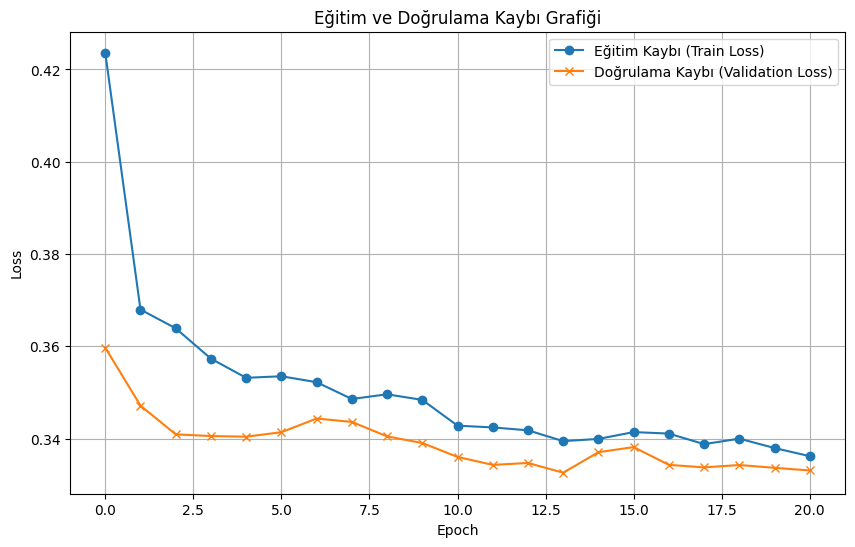

<ipython-input-8-cb1b2a9ea43d>:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vanilla_transformer_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 15.05
Gün 2: 14.55
Gün 3: 14.11
Gün 4: 13.79
Gün 5: 13.52
Gün 6: 13.26
Gün 7: 13.01

Dew Point için tahminler:
Gün 1: 9.95
Gün 2: 9.63
Gün 3: 9.30
Gün 4: 8.92
Gün 5: 8.52
Gün 6: 8.11
Gün 7: 7.72

Humidity için tahminler:
Gün 1: 74.15
Gün 2: 74.74
Gün 3: 74.96
Gün 4: 74.85
Gün 5: 74.53
Gün 6: 74.18
Gün 7: 73.90

Wind Speed için tahminler:
Gün 1: 10.45
Gün 2: 9.86
Gün 3: 9.41
Gün 4: 9.09
Gün 5: 8.87
Gün 6: 8.72
Gün 7: 8.62

Pressure için tahminler:
Gün 1: 29.83
Gün 2: 29.81
Gün 3: 29.79
Gün 4: 29.77
Gün 5: 29.76
Gün 6: 29.75
Gün 7: 29.74


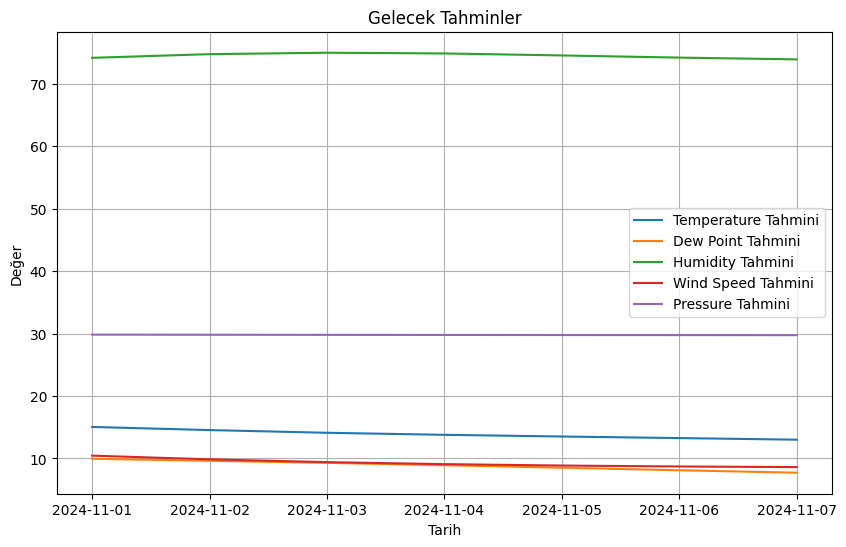

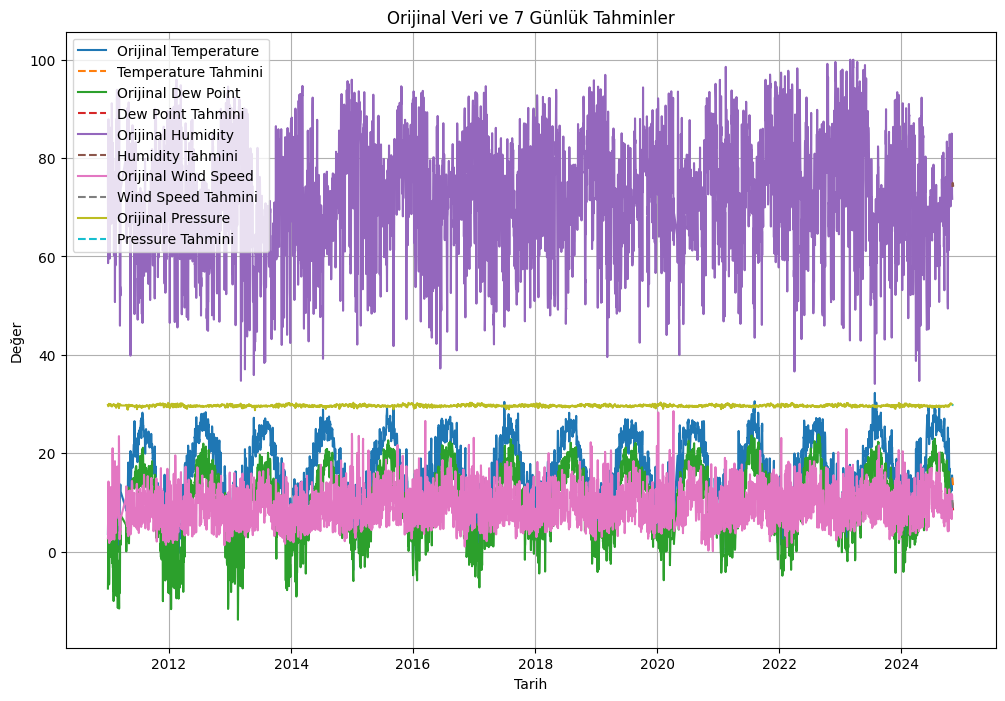

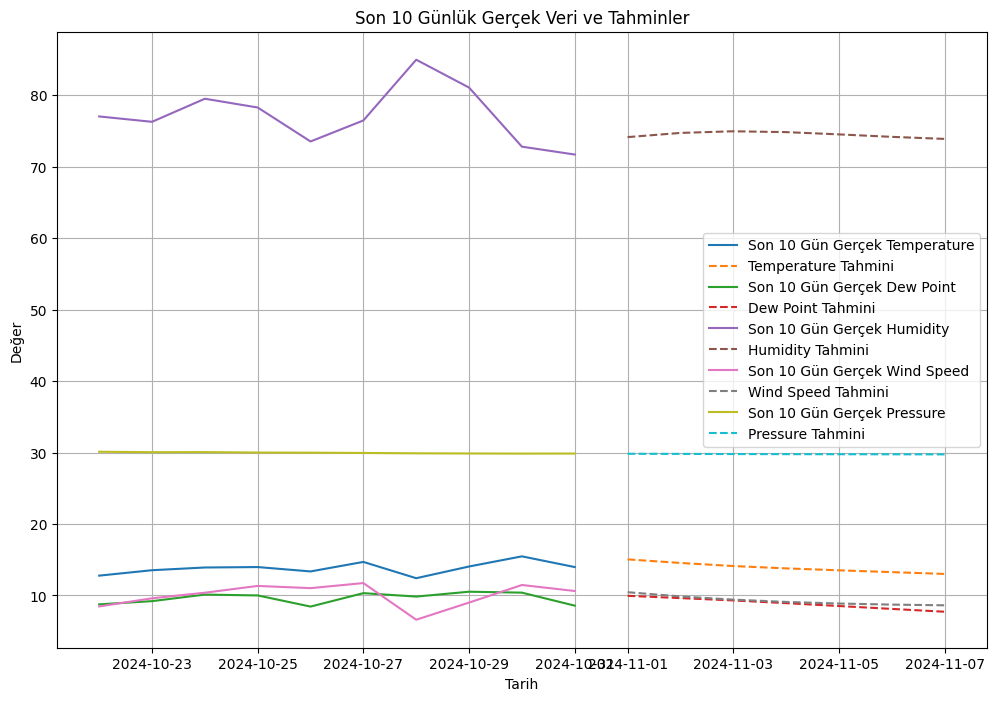

Training Time: 83.81 seconds
Inference Time: 0.02 seconds


In [ ]:
#VANİLLA MODELİ (ENCODER)
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time

# Vanilla Transformer Modeli
class VanillaTransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8):
        super(VanillaTransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.rand(1, 500, hidden_size))  # Position Encoding (zaman serisi için)

        # Vanilla Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size*4
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Giriş projeksiyonunu uygulama
        x = self.input_projection(x)

        # Positional encoding ekle
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Son zaman adımındaki tahmin
        output = self.fc(x[:, -1, :])  # Son adım
        return output

# Model parametreleri
input_size = 5  # Özellik sayısı
hidden_size = 32
num_layers = 2
output_size = 5
learning_rate = 0.001
epochs = 35
num_heads = 4
patience = 7

# Modeli oluştur
model = VanillaTransformerModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, num_heads=num_heads)

# Kayıp fonksiyonu ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'vanilla_transformer_model.pth')  # En iyi modeli kaydet
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()  # Modeli değerlendirme moduna geçirin
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).numpy()  # Modelin test seti tahminlerini al

# Test setindeki gerçek değerler
y_test_actual = y_test_tensor.numpy()  # Test setinin gerçek değerlerini numpy array'e dönüştür

# Metriklerin hesaplanması
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            # Yeni tahminlerle sekansı güncelle
            current_sequence = np.vstack([current_sequence[1:], prediction])

    # Tahminleri orijinal ölçeğe geri döndür
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Tahmin için son sekansı al
last_sequence = X_test[-1]
future_days = 7  # Tahmin yapmak istediğiniz gün sayısı

# En iyi modeli yükle
model.load_state_dict(torch.load('vanilla_transformer_model.pth'))

# Tahminleri oluştur
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")



Epoch 1/35 - Training Loss: 0.4596 - Validation Loss: 0.3789
Epoch 2/35 - Training Loss: 0.3875 - Validation Loss: 0.3532
Epoch 3/35 - Training Loss: 0.3692 - Validation Loss: 0.3432
Epoch 4/35 - Training Loss: 0.3643 - Validation Loss: 0.3502
Epoch 5/35 - Training Loss: 0.3556 - Validation Loss: 0.3435
Epoch 6/35 - Training Loss: 0.3498 - Validation Loss: 0.3533
Epoch 7/35 - Training Loss: 0.3442 - Validation Loss: 0.3384
Epoch 8/35 - Training Loss: 0.3366 - Validation Loss: 0.3492
Epoch 9/35 - Training Loss: 0.3307 - Validation Loss: 0.3579
Epoch 10/35 - Training Loss: 0.3314 - Validation Loss: 0.3549
Epoch 11/35 - Training Loss: 0.3068 - Validation Loss: 0.3392
Epoch 12/35 - Training Loss: 0.2997 - Validation Loss: 0.3452
Epoch 13/35 - Training Loss: 0.2932 - Validation Loss: 0.3539
Epoch 14/35 - Training Loss: 0.2901 - Validation Loss: 0.3521
Early stopping triggered.
=== Test Seti Performansı ===
MSE: 0.3531
MAE: 0.4150
RMSE: 0.5943
R²: 0.6502
MAPE: 2.0166


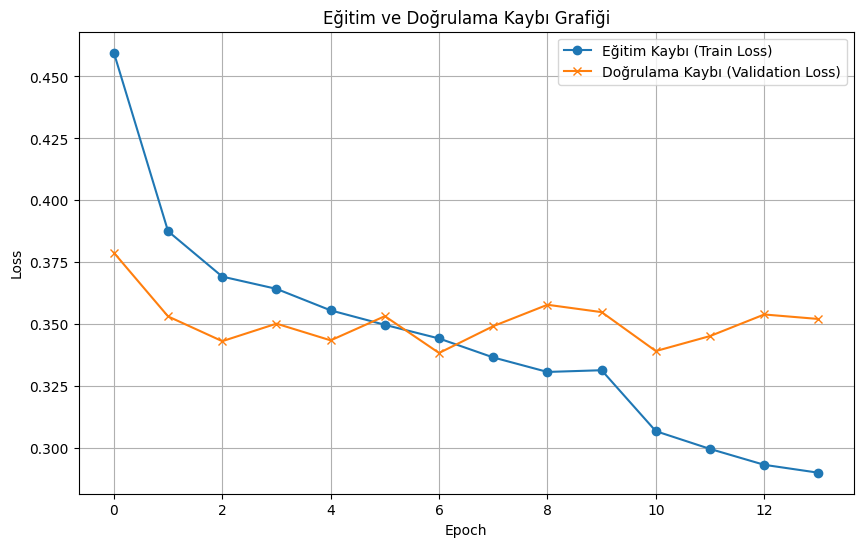

<ipython-input-28-d27496a93935>:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tst_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 15.23
Gün 2: 15.04
Gün 3: 14.66
Gün 4: 14.37
Gün 5: 14.21
Gün 6: 14.22
Gün 7: 14.43

Dew Point için tahminler:
Gün 1: 11.08
Gün 2: 11.09
Gün 3: 10.90
Gün 4: 10.74
Gün 5: 10.49
Gün 6: 10.33
Gün 7: 10.39

Humidity için tahminler:
Gün 1: 76.20
Gün 2: 78.02
Gün 3: 78.94
Gün 4: 79.07
Gün 5: 79.11
Gün 6: 78.75
Gün 7: 78.22

Wind Speed için tahminler:
Gün 1: 9.29
Gün 2: 8.07
Gün 3: 7.54
Gün 4: 7.41
Gün 5: 7.42
Gün 6: 7.68
Gün 7: 7.91

Pressure için tahminler:
Gün 1: 29.83
Gün 2: 29.80
Gün 3: 29.78
Gün 4: 29.78
Gün 5: 29.78
Gün 6: 29.78
Gün 7: 29.78


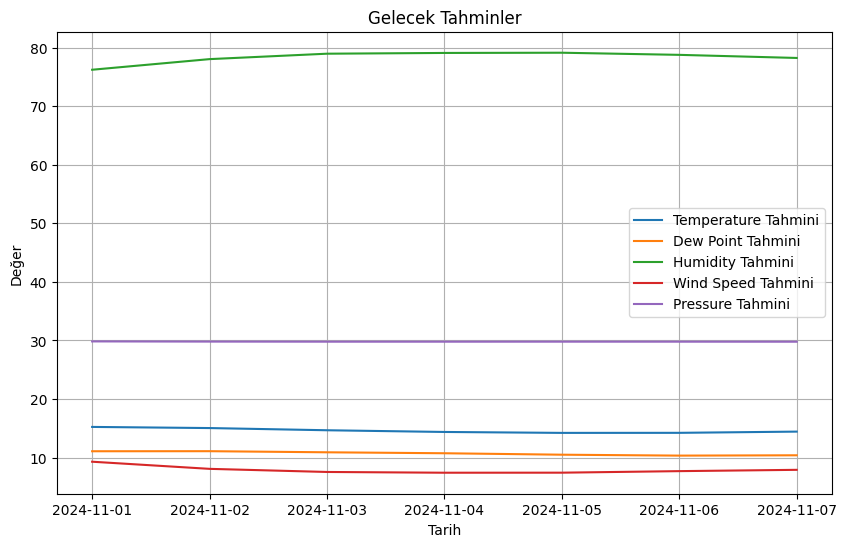

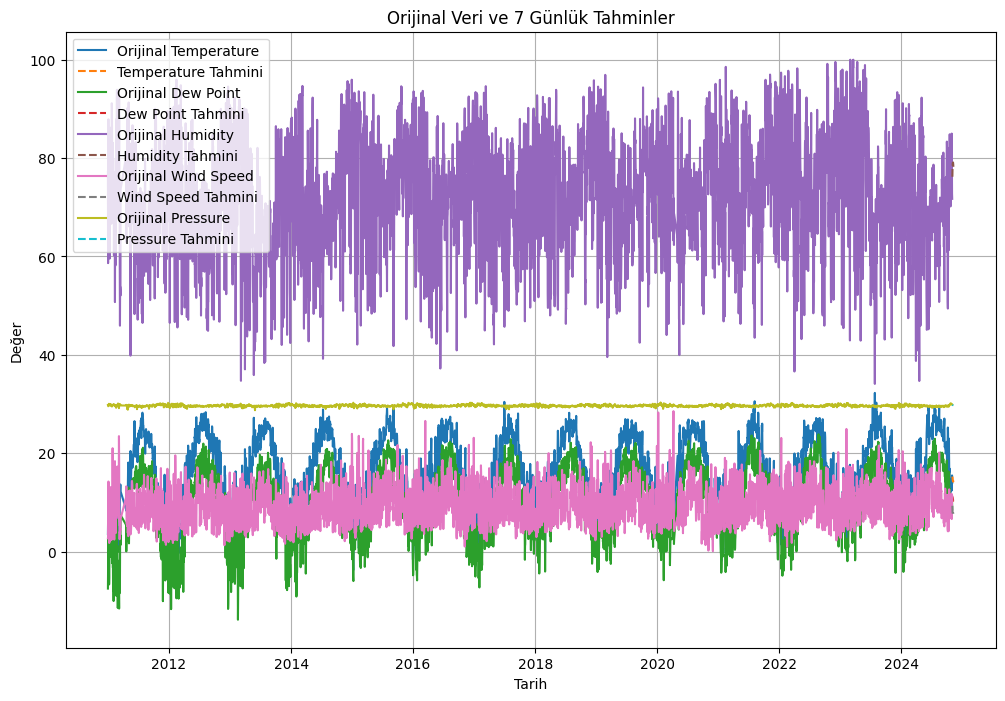

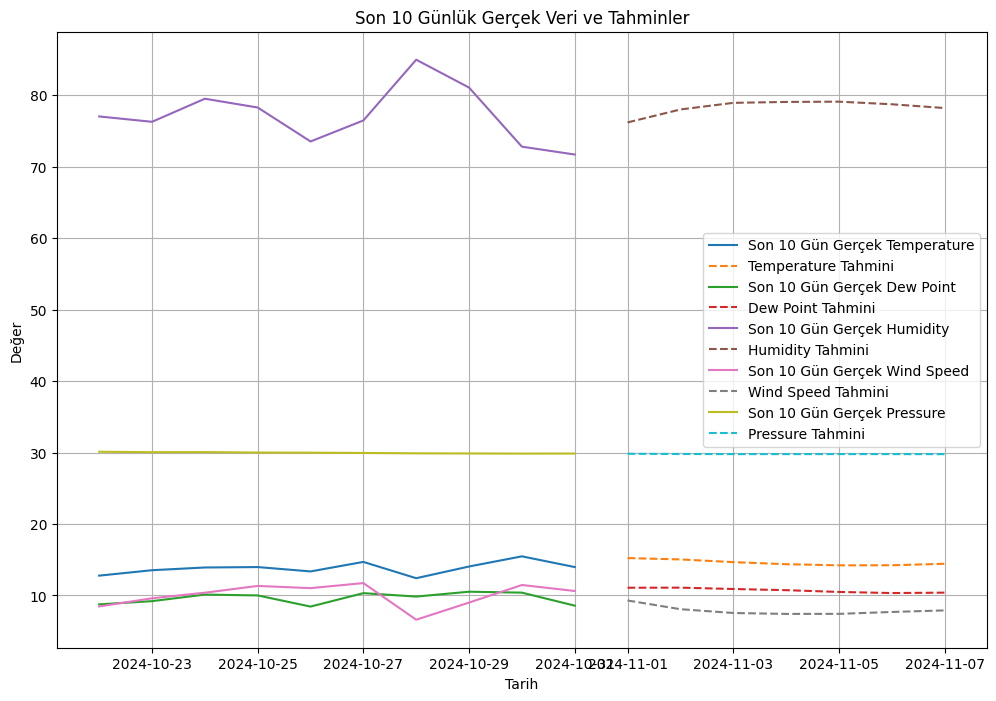

Training Time: 285.38 seconds
Inference Time: 0.05 seconds


In [ ]:
#TST MODELİ
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time

# CSV dosyasını yükle
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')

# Transformer-Tabanlı Zaman Serisi Modeli (TST)
class TSTModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, seq_len):
        super(TSTModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim * 4,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_projection(x)  # Giriş projeksiyonu
        x = x + self.positional_encoding  # Pozisyon kodlaması ekleme
        x = self.transformer(x, x)  # Encoder-Decoder yapısı
        output = self.fc(x[:, -1, :])  # Son zaman adımındaki tahmin
        return output
# Model parametreleri
input_size = 5  # Özellik sayısı
hidden_size = 64
num_layers = 2
num_heads = 4
output_size = 5
seq_length = 30  # Pencere boyutu
learning_rate = 0.001
epochs = 35
patience = 7

# Modeli oluştur
model = TSTModel(
    input_dim=input_size,
    hidden_dim=hidden_size,
    num_layers=num_layers,
    num_heads=num_heads,
    output_dim=output_size,
    seq_len=seq_length
)

# Kayıp fonksiyonu ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_tst_model.pth')  # En iyi modeli kaydet
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()  # Modeli değerlendirme moduna geçirin
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).numpy()  # Modelin test seti tahminlerini al

# Test setindeki gerçek değerler
y_test_actual = y_test_tensor.numpy()  # Test setinin gerçek değerlerini numpy array'e dönüştür

# Metriklerin hesaplanması
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            # Yeni tahminlerle sekansı güncelle
            current_sequence = np.vstack([current_sequence[1:], prediction])

    # Tahminleri orijinal ölçeğe geri döndür
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Tahmin için son sekansı al
last_sequence = X_test[-1]
future_days = 7  # Tahmin yapmak istediğiniz gün sayısı

# En iyi modeli yükle
model.load_state_dict(torch.load('best_tst_model.pth'))

# Tahminleri oluştur
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

Epoch 1/35 - Training Loss: 0.5096 - Validation Loss: 0.4452
Epoch 2/35 - Training Loss: 0.4489 - Validation Loss: 0.4434
Epoch 3/35 - Training Loss: 0.4285 - Validation Loss: 0.4113
Epoch 4/35 - Training Loss: 0.4181 - Validation Loss: 0.4173
Epoch 5/35 - Training Loss: 0.3978 - Validation Loss: 0.4029
Epoch 6/35 - Training Loss: 0.3953 - Validation Loss: 0.4179
Epoch 7/35 - Training Loss: 0.3984 - Validation Loss: 0.4027
Epoch 8/35 - Training Loss: 0.3888 - Validation Loss: 0.4051
Epoch 9/35 - Training Loss: 0.3669 - Validation Loss: 0.4105
Epoch 10/35 - Training Loss: 0.3639 - Validation Loss: 0.4120
Epoch 11/35 - Training Loss: 0.3399 - Validation Loss: 0.4051
Epoch 12/35 - Training Loss: 0.3345 - Validation Loss: 0.3961
Epoch 13/35 - Training Loss: 0.3292 - Validation Loss: 0.4056
Epoch 14/35 - Training Loss: 0.3213 - Validation Loss: 0.4160
Epoch 15/35 - Training Loss: 0.3197 - Validation Loss: 0.4029
Epoch 16/35 - Training Loss: 0.3128 - Validation Loss: 0.4069
Epoch 17/35 - Tra

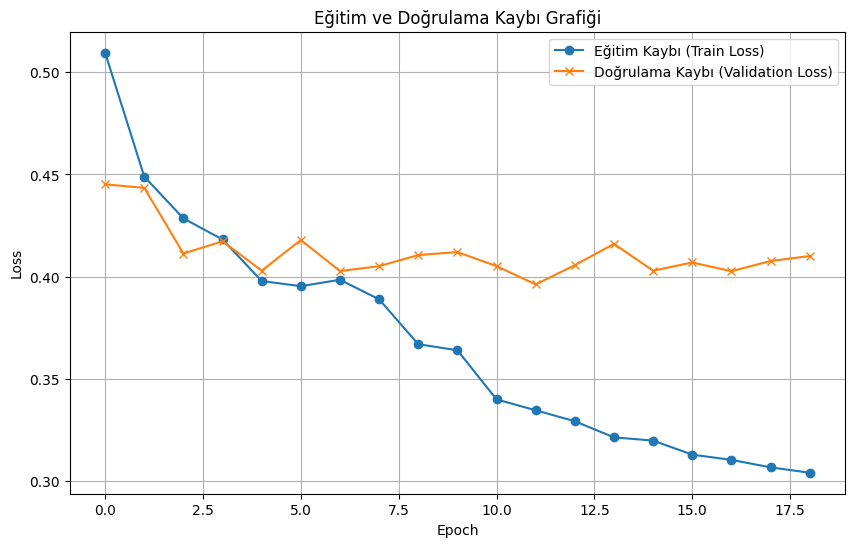

<ipython-input-6-501102ea3be8>:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_informer_model.pth'))


7 Günlük Tahminler:

Temperature için tahminler:
Gün 1: 15.28
Gün 2: 14.89
Gün 3: 15.47
Gün 4: 15.46
Gün 5: 14.92
Gün 6: 14.60
Gün 7: 13.84

Dew Point için tahminler:
Gün 1: 11.91
Gün 2: 11.42
Gün 3: 11.74
Gün 4: 12.15
Gün 5: 12.02
Gün 6: 11.35
Gün 7: 10.14

Humidity için tahminler:
Gün 1: 79.83
Gün 2: 80.88
Gün 3: 79.35
Gün 4: 80.91
Gün 5: 82.50
Gün 6: 80.62
Gün 7: 79.87

Wind Speed için tahminler:
Gün 1: 8.85
Gün 2: 7.81
Gün 3: 7.01
Gün 4: 6.49
Gün 5: 7.04
Gün 6: 7.35
Gün 7: 7.44

Pressure için tahminler:
Gün 1: 29.83
Gün 2: 29.79
Gün 3: 29.73
Gün 4: 29.71
Gün 5: 29.76
Gün 6: 29.82
Gün 7: 29.84


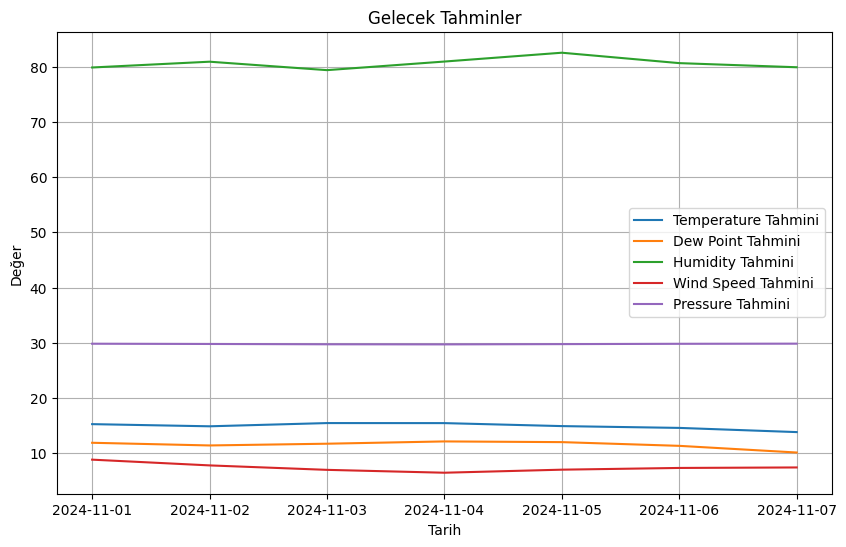

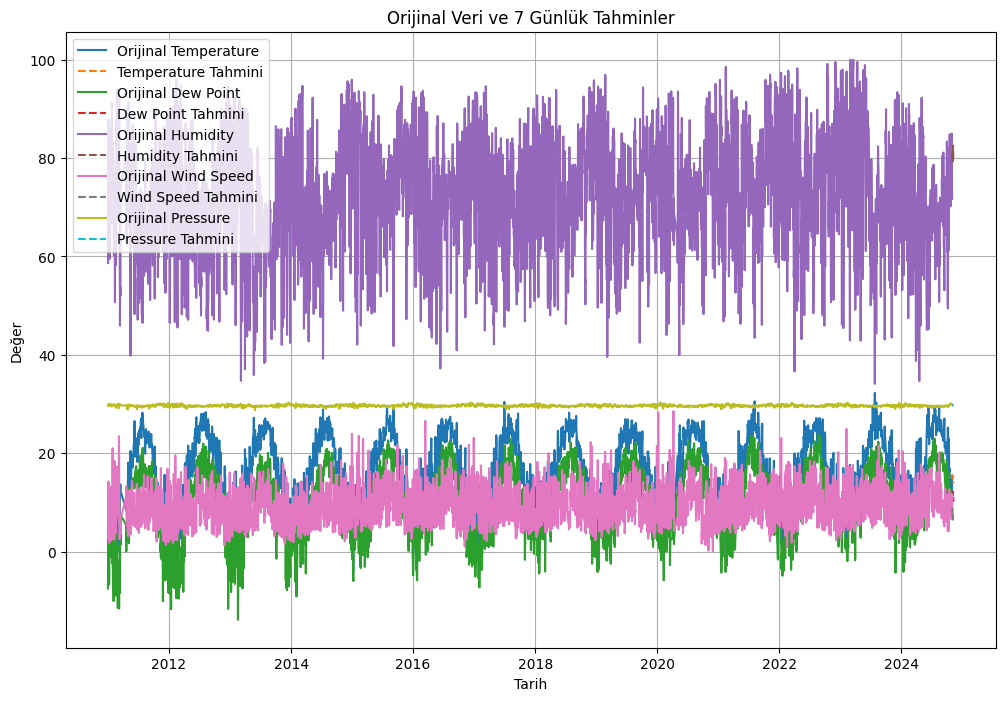

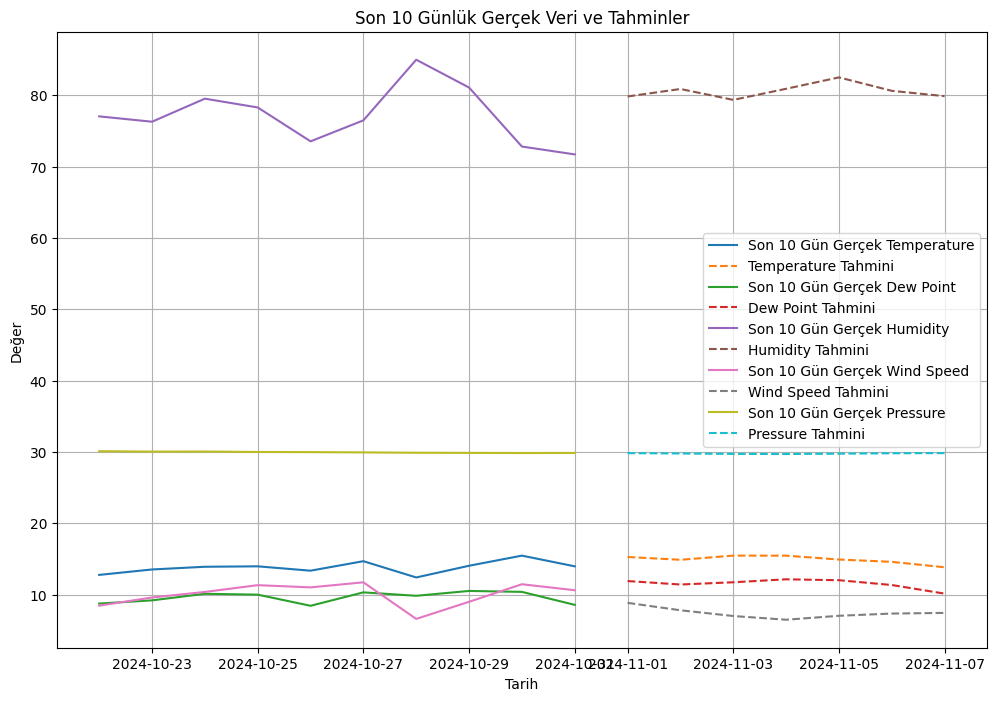

Training Time: 212.57 seconds
Inference Time: 0.04 seconds


In [ ]:
#INFORMER MODELİ
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import time

# Import the Informer model from the correct path
from models.model import Informer

# CSV dosyasını yükle
df = pd.read_csv('/content/drive/MyDrive/daily_data.csv')


class InformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8):
        super(InformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)

        # Define the Informer model
        self.informer = Informer(
            enc_in=input_size,  # Number of input features
            dec_in=hidden_size,  # Hidden layer size
            c_out=output_size,  # Output size
            seq_len=30,  # Sequence length (use your actual sequence length)
            label_len=10,  # Label length (adjust based on your problem)
            out_len=5,  # Output length (you can modify this based on your use case)
            d_model=hidden_size,  # Dimensionality of the model
            n_heads=num_heads,  # Number of attention heads
            e_layers=num_layers,  # Encoder layers
            d_layers=2,  # Decoder layers (adjust as needed)
            dropout=0.1,  # Dropout rate
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_projection(x)  # Apply input projection
        # The output of the Informer encoder is a tuple, we need to extract the first element (the encoder output)
        encoder_output, _ = self.informer.encoder(x)  # Assuming the first element is the encoder output
        output = self.fc(encoder_output[:, -1, :])  # Use the last time step for prediction
        return output



# Model parametreleri
input_size = 5  # Özellik sayısı
hidden_size = 32
num_layers = 2
output_size = 5
learning_rate = 0.001
epochs = 35
num_heads = 4
patience = 7

# Modeli oluştur
model = InformerModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, num_heads=num_heads)

# Kayıp fonksiyonu ve optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Veriyi yüklemek ve ölçeklendirmek
scaler = StandardScaler()
data = df[['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']].values
scaled_data = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Zaman serisi verisini 3D hale getirmek
def create_sequences(data, seq_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Eğitim ve test verisi oluşturma
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Tensor formatına çevirme
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# DataLoader oluşturma
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Eğitim döngüsü
train_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_batch in validation_loader:
            val_inputs, val_targets = val_batch
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            validation_loss += val_loss.item()

    val_loss = validation_loss / len(validation_loader)
    validation_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_informer_model.pth')  # En iyi modeli kaydet
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
training_time = end_training_time - start_training_time

# Test seti tahminlerini yapmak
model.eval()  # Modeli değerlendirme moduna geçirin
with torch.no_grad():
    y_test_predictions = model(X_test_tensor).numpy()  # Modelin test seti tahminlerini al

# Test setindeki gerçek değerler
y_test_actual = y_test_tensor.numpy()  # Test setinin gerçek değerlerini numpy array'e dönüştür

# Metriklerin hesaplanması
mse_test = mean_squared_error(y_test_actual, y_test_predictions)
mae_test = mean_absolute_error(y_test_actual, y_test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_actual, y_test_predictions)
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_predictions)

# Performans metriklerini yazdırma
print(f"=== Test Seti Performansı ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Eğitim Kaybı (Train Loss)', marker='o')
plt.plot(range(len(validation_losses)), validation_losses, label='Doğrulama Kaybı (Validation Loss)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.grid()
plt.show()

# Gelecek tahminler için fonksiyon
def forecast_future(model, last_sequence, scaler, input_size, future_days):
    model.eval()
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_days):
        with torch.no_grad():
            input_tensor = torch.Tensor(current_sequence).unsqueeze(0)  # Batch boyutunu ekle
            prediction = model(input_tensor).squeeze(0).numpy()  # Tahmin yap
            future_predictions.append(prediction)
            # Yeni tahminlerle sekansı güncelle
            current_sequence = np.vstack([current_sequence[1:], prediction])

    # Tahminleri orijinal ölçeğe geri döndür
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

# Tahmin için son sekansı al
last_sequence = X_test[-1]
future_days = 7  # Tahmin yapmak istediğiniz gün sayısı

# En iyi modeli yükle
model.load_state_dict(torch.load('best_informer_model.pth'))

# Tahminleri oluştur
future_predictions = forecast_future(model, last_sequence, scaler, input_size, future_days)

# Sayısal sütunların isimleri
feature_names = ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']

# Tahminleri düzenli bir şekilde yazdırma
print("7 Günlük Tahminler:")
for i, feature in enumerate(feature_names):
    print(f"\n{feature} için tahminler:")
    for day, prediction in enumerate(future_predictions[:, i], start=1):
        print(f"Gün {day}: {prediction:.2f}")

# Tahminleri çizme
dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_days + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
for i, label in enumerate(feature_names):
    plt.plot(dates, future_predictions[:, i], label=f'{label} Tahmini')

plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.title('Gelecek Tahminler')
plt.legend()
plt.grid()
plt.show()

# Orijinal veri ve tahminleri karşılaştırma
original_dates = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(original_dates, df[label], label=f'Orijinal {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Orijinal Veri ve 7 Günlük Tahminler")
plt.legend()
plt.grid()
plt.show()

# Son 10 günlük gerçek veri ve tahminlerin karşılaştırılması
zoomed_original_dates = original_dates.iloc[-10:]
zoomed_original_data = df.iloc[-10:][feature_names]

plt.figure(figsize=(12, 8))
for i, label in enumerate(feature_names):
    plt.plot(zoomed_original_dates, zoomed_original_data[label], label=f'Son 10 Gün Gerçek {label}')
    plt.plot(dates, future_predictions[:, i], linestyle='--', label=f'{label} Tahmini')

plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.title("Son 10 Günlük Gerçek Veri ve Tahminler")
plt.legend()
plt.grid()
plt.show()

# Çıkarım zamanı ölçümü
start_inference_time = time.time()
_ = forecast_future(model, last_sequence, scaler, input_size, future_days)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

<ipython-input-1-ea046c7b9d6c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='MSE', palette='viridis')


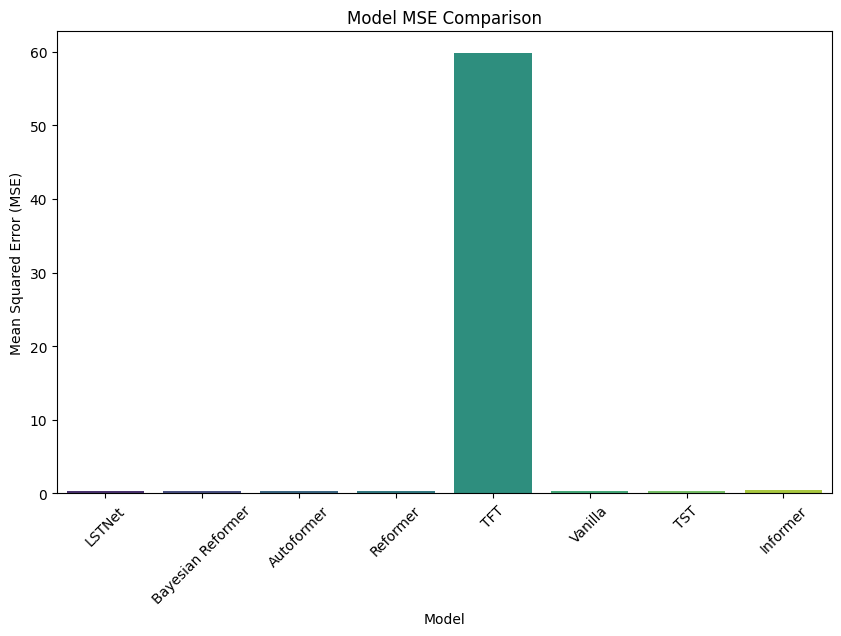

<ipython-input-1-ea046c7b9d6c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Training Time (s)', palette='viridis')


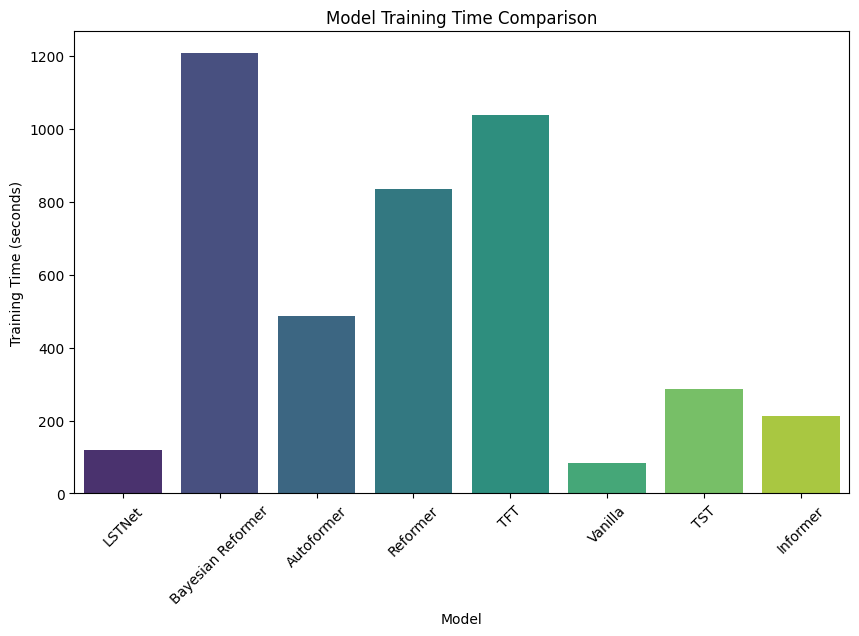

<ipython-input-1-ea046c7b9d6c>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='R2', palette='viridis')


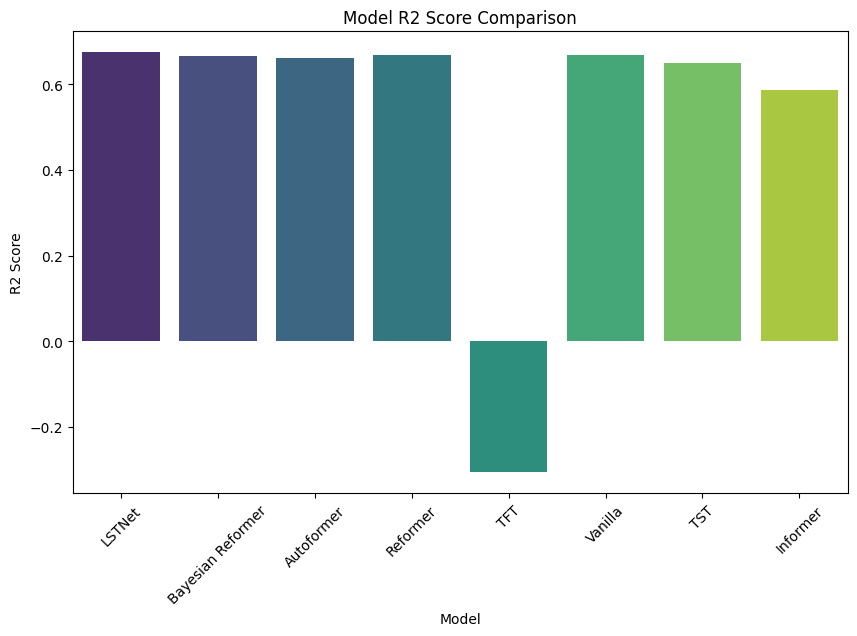

<ipython-input-1-ea046c7b9d6c>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='MAPE', palette='viridis', log=True)


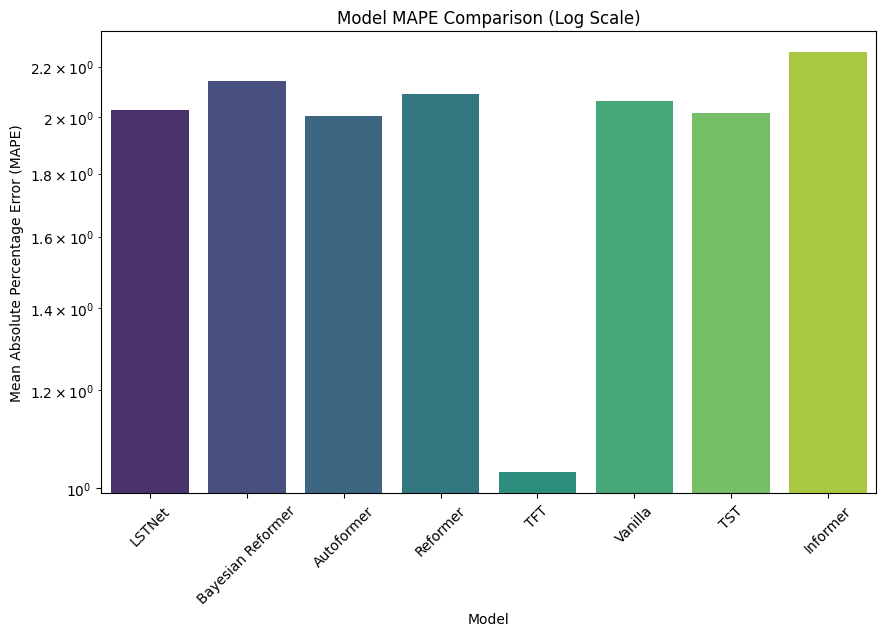

<ipython-input-1-ea046c7b9d6c>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=normalized_df, x='Model', y='Overall Score', palette='viridis')


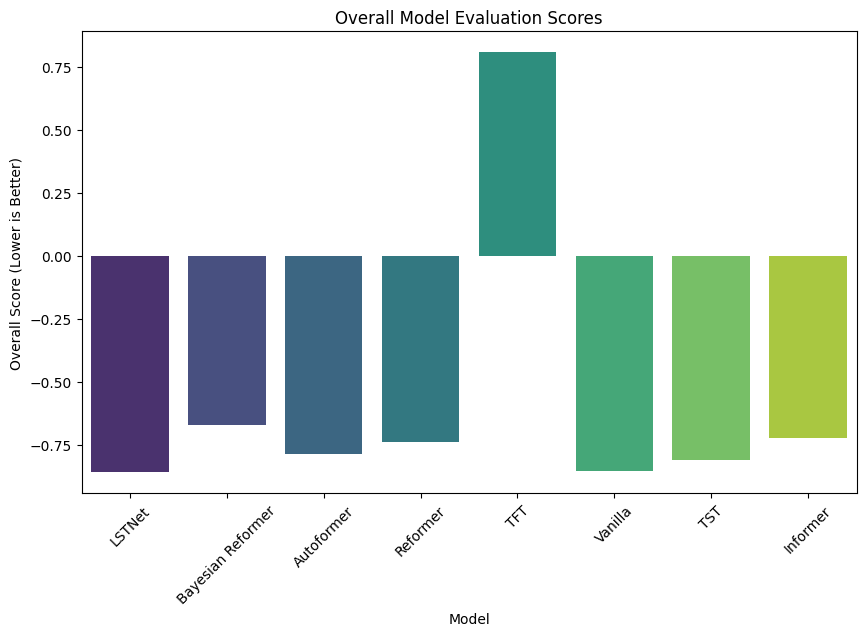

Model        MSE       MAE      RMSE        R2      MAPE  \
0             LSTNet   0.328300  0.400700  0.573000  0.674500  2.026500   
1  Bayesian Reformer   0.336800  0.403200  0.580300  0.665700  2.139700   
2         Autoformer   0.340408  0.409834  0.583445  0.661667  2.004774   
3           Reformer   0.334000  0.400700  0.577900  0.668300  2.091000   
4                TFT  59.747400  5.165300  6.517400 -0.306300  1.029300   
5            Vanilla   0.333000  0.402500  0.577000  0.669400  2.064400   
6                TST   0.353100  0.415000  0.594300  0.650200  2.016600   
7           Informer   0.412100  0.456900  0.642000  0.586900  2.258700   

   Training Time (s)  Inference Time (s)  Overall Score  
0             120.14                0.02      -0.859417  
1            1206.08                0.13      -0.672644  
2             487.60                1.21      -0.784683  
3             834.09                0.12      -0.737382  
4            1036.72               21.17       0.808182  
5              83.81                0.02      -0.854286  
6             285.38                0.05      -0.810040  
7             212.57                0.04      -0.720603

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# PERFORMANS KARŞILAŞTIRMALARI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Verileri oluşturma
data = {
    'Model': ['LSTNet', 'Bayesian Reformer', 'Autoformer', 'Reformer', 'TFT', 'Vanilla', 'TST', 'Informer'],
    'MSE': [0.3283, 0.3368, 0.3404075503349304, 0.3340, 59.7474, 0.3330, 0.3531, 0.4121],
    'MAE': [0.4007, 0.4032, 0.40983375906944275, 0.4007, 5.1653, 0.4025, 0.4150, 0.4569],
    'RMSE': [0.5730, 0.5803, 0.5834445563504131, 0.5779, 6.5174, 0.5770, 0.5943, 0.6420],
    'R2': [0.6745, 0.6657, 0.6616665124893188, 0.6683, -0.3063, 0.6694, 0.6502, 0.5869],
    'MAPE': [2.0265, 2.1397, 2.004774332046509, 2.0910, 1.0293, 2.0644, 2.0166, 2.2587],
    'Training Time (s)': [120.14, 1206.08, 487.60, 834.09, 1036.72, 83.81, 285.38, 212.57],
    'Inference Time (s)': [0.02, 0.13, 1.21, 0.12, 21.17, 0.02, 0.05, 0.04]
}

df = pd.DataFrame(data)

# Performans karşılaştırmasını görselleştirme
# 1. MSE Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='MSE', palette='viridis')
plt.title('Model MSE Comparison')
plt.xticks(rotation=45)
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# 2. Eğitim Süresi Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='Training Time (s)', palette='viridis')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
plt.ylabel('Training Time (seconds)')
plt.show()

# 3. R2 Değerleri Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='R2', palette='viridis')
plt.title('Model R2 Score Comparison')
plt.xticks(rotation=45)
plt.ylabel('R2 Score')
plt.show()

# 4. MAPE Karşılaştırması (Log Ölçeği ile, büyük değer farkları nedeniyle)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='MAPE', palette='viridis', log=True)
plt.title('Model MAPE Comparison (Log Scale)')
plt.xticks(rotation=45)
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.show()

# Normalleştirme
metrics = ['MSE', 'MAE', 'RMSE', 'R2', 'MAPE', 'Training Time (s)', 'Inference Time (s)']
scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df[metrics])

# Normalize edilmiş metriklerle genel skor hesaplama
normalized_df = pd.DataFrame(scaled_metrics, columns=metrics)
normalized_df['Model'] = df['Model']
normalized_df['Overall Score'] = normalized_df[['MSE', 'MAE', 'RMSE', 'MAPE', 'Training Time (s)', 'Inference Time (s)']].mean(axis=1) - normalized_df['R2']

plt.figure(figsize=(10, 6))
sns.barplot(data=normalized_df, x='Model', y='Overall Score', palette='viridis')
plt.title('Overall Model Evaluation Scores')
plt.xticks(rotation=45)
plt.ylabel('Overall Score (Lower is Better)')
plt.show()

# Genel skorları orijinal tabloya ekleme
df['Overall Score'] = normalized_df['Overall Score']

# Tabloyu görüntüleme
from IPython.display import display
display(df)

# Tabloyu CSV olarak kaydetme
df.to_csv('model_performance_with_overall_score.csv', index=False)

# Colab üzerinden indirme
from google.colab import files
files.download('model_performance_with_overall_score.csv')
